# Fraud Detection on Fintech Platforms Using Machine Learning From Prediksi Team

## Description
This project aims to develop a machine learning model to detect fraud in fintech platform users. In addition to developing a classification model, an analysis of the pattern of users identified as fraud is also needed to explain how the model works.

## What is Fraud Detection?
Fraud detection is the process of identifying whether a user's actions in a scenario are fraudulent or not. In the context of this project, an act of fraud is defined as a platform user who has borrowed a financial product but is recorded as having not made a payment by a predetermined deadline.

## Objectives and Goals
The main objective of this project is to build a machine learning model that can detect fraudulent activities with high accuracy. The specific goals include:
1. Collecting and cleaning user transaction data.
2. Exploring the most influential features for fraud detection.
3. Developing and comparing several machine learning algorithms to find the best model.
4. Analyzing patterns and characteristics of users identified as fraudulent.
5. Evaluating the model's performance using appropriate metrics.

## Methodology
We will use a classification approach to detect fraudulent activities. Several algorithms that will be tested include logistic regression, random forest, GNN, and XG Boosting.

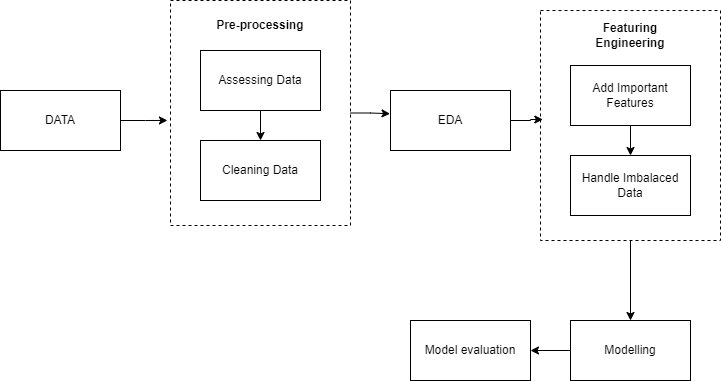

# Import Library

In [ ]:

import pandas as pd
import numpy as np
import sklearn
import imblearn
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gdown
import zipfile
import logging
from genericpath import isdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.metrics import average_precision_score, confusion_matrix, classification_report

#Preprocessing Data

## Gathering data

```
The dataset consists of five CSV files with the following details:

1. train.csv - Contains user data for training the model.
user_id: User ID.
pc[0-16]: A set of anonymized user identity features.
label: Target classification label for the user (0: Non-fraud; 1: Fraud).

2. loan_activities.csv - Contains records of financial product loans on the platform.
user_id: User ID.
reference_contact: Another user designated as an emergency contact.
loan_type: Type of loan ordered by the user.
ts: Timestamp when the user made the loan.

3. non_borrower_user.csv - Contains data on users who are not targets for classification due to their infrequent loan activities.
user_id: User ID.
pc[0-16]: A set of anonymized user identity features.

4. test.csv - Contains user data for prediction in the submission.
user_id: User ID matching the sample_submission.csv file.
pc[0-16]: A set of anonymized user identity features.

5. sample_submission.csv - Contains a sample submission.
user_id: User ID matching the test.csv file.
label: Target classification label for the user (0: Non-fraud; 1: Fraud).

```

In [ ]:
def download_data(url, filename, dir_name: str = "data") -> None:
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    os.chdir(dir_name)
    logging.info("Downloading data....")
    gdown.download(
        url, quiet=False
    )
    logging.info("Extracting zip file....")
    with zipfile.ZipFile(f"{filename}.zip", 'r') as zip_ref:
        zip_ref.extractall(filename)
    os.remove(f"{filename}.zip")
    os.chdir("..")

download_data(url="https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj",
              filename="ristek-datathon-2024",
              dir_name="datathon-2024")

Downloading...
From (original): https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj
From (redirected): https://drive.google.com/uc?id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj&confirm=t&uuid=bc3addc6-191b-417b-b7fc-fd05761a2926
To: /content/datathon-2024/ristek-datathon-2024.zip
100%|██████████| 113M/113M [00:00<00:00, 125MB/s]


In [ ]:
# load data train
train = pd.read_csv('/content/datathon-2024/ristek-datathon-2024/ristek-datathon-2024/train.csv')
train.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0


In [ ]:
# load data loan activities
loan_activities = pd.read_csv('/content/datathon-2024/ristek-datathon-2024/ristek-datathon-2024/loan_activities.csv')
loan_activities.head()

,user_id,reference_contact,loan_type,ts
0,2223129,903716,1,671
1,1380939,484583,1,89
2,2724411,1185034,1,230
3,2401751,1369254,1,120
4,1982168,21797,1,57


In [ ]:
# load data non_borrower_user
non_borrower_user = pd.read_csv('/content/datathon-2024/ristek-datathon-2024/ristek-datathon-2024/non_borrower_user.csv')
non_borrower_user.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1,5,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
1,1,0,8,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1,0.103175,0.006092,0.053097,1.0,0.007937,0.166667
2,2,-1,-1,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
3,6,0,1,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
4,7,1,6,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000


In [ ]:
# load data test
test = pd.read_csv('/content/datathon-2024/ristek-datathon-2024/ristek-datathon-2024/test.csv')
test.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,13,1.0,5.0,0.445,0.420,0.943820,0.8,0.783,0.234,0.778,0.993614,2.0,0.056180,0.006386,0.095238,0.750000,0.022472,0.250000
2,37,1.0,6.0,1.680,1.080,0.642857,0.6,1.167,0.046,1.007,0.862896,1.0,0.357143,0.137104,0.027778,0.500000,0.002976,0.166667
3,61,0.0,3.0,1.505,0.875,0.581395,0.9,0.425,0.012,0.286,0.672941,1.0,0.418605,0.327059,0.051429,0.333333,0.003322,0.111111
4,66,1.0,5.0,2.210,1.075,0.486425,1.0,1.349,0.087,1.015,0.752409,2.0,0.513575,0.247591,0.046512,0.800000,0.004525,0.200000


## Assesing Data

### Assessing data train

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 MB


In [ ]:
train.isna().sum()

user_id    0
pc0        0
pc1        0
pc2        0
pc3        0
pc4        0
pc5        0
pc6        0
pc7        0
pc8        0
pc9        0
pc10       0
pc11       0
pc12       0
pc13       0
pc14       0
pc15       0
pc16       0
label      0
dtype: int64

There are no missing values in the training dataset

In [ ]:
print("Number of duplicate data: ", train.duplicated().sum())

Number of duplicate data:  0


There are no duplicate data in the training dataset

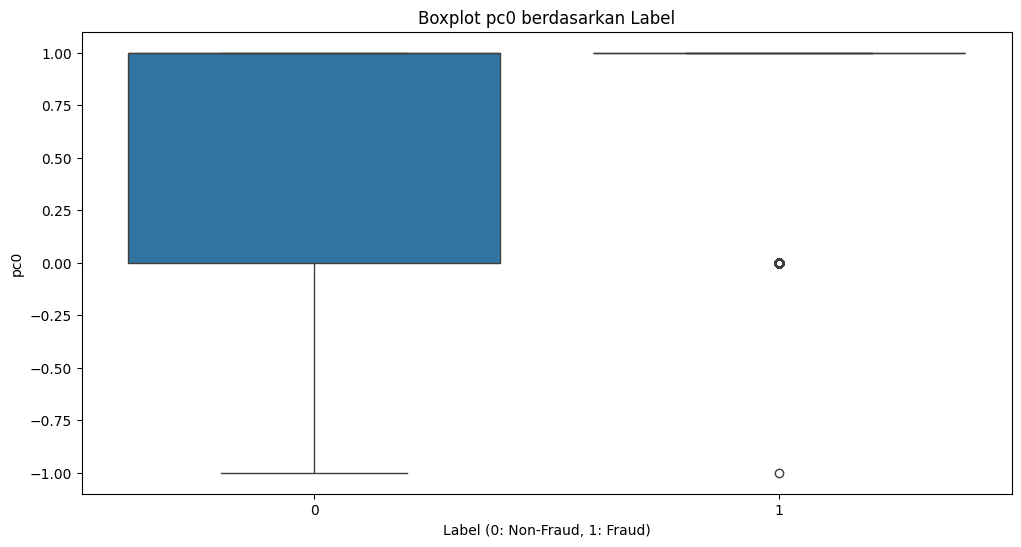

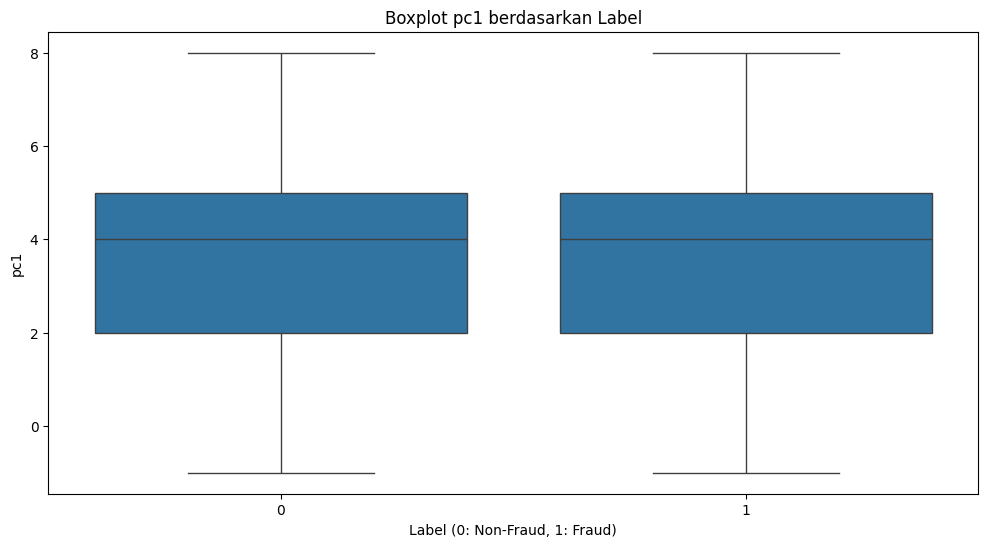

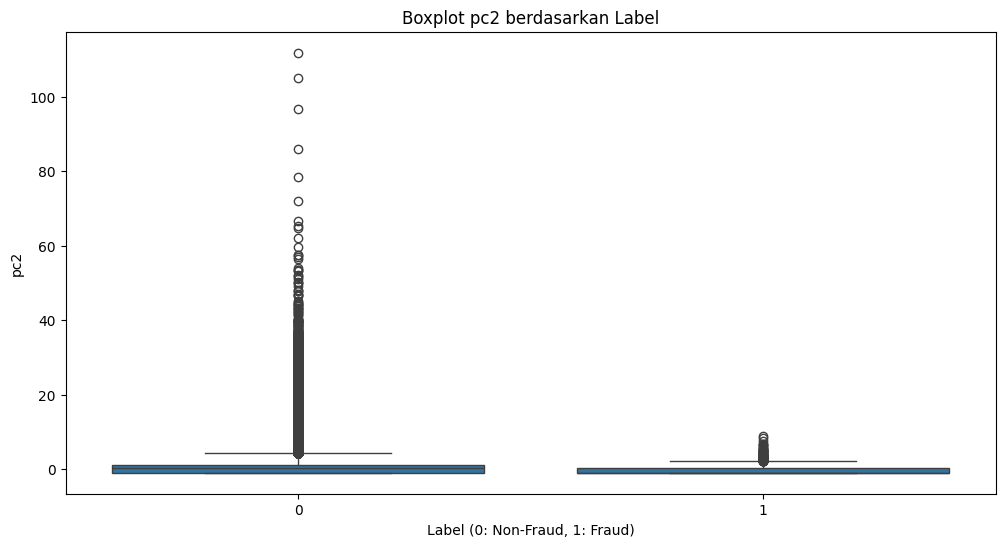

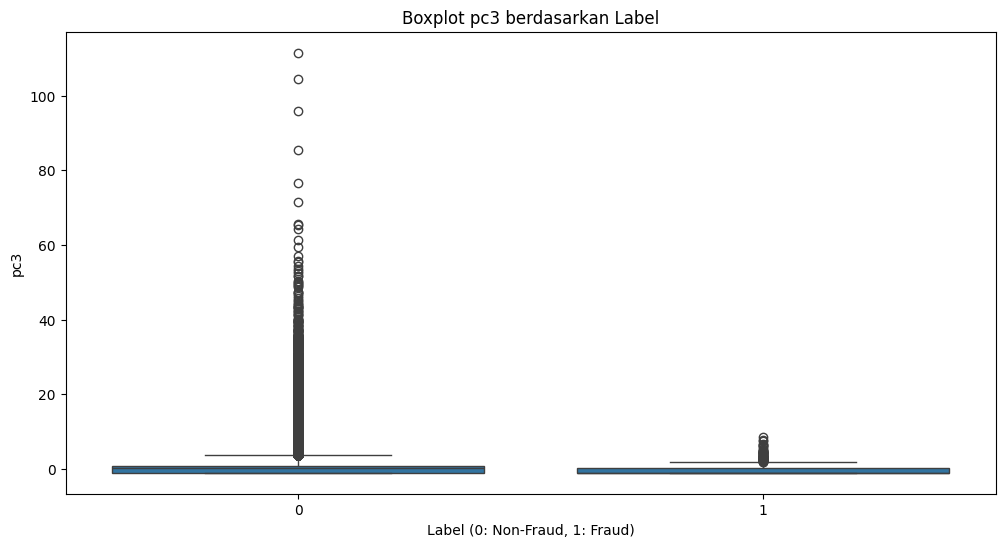

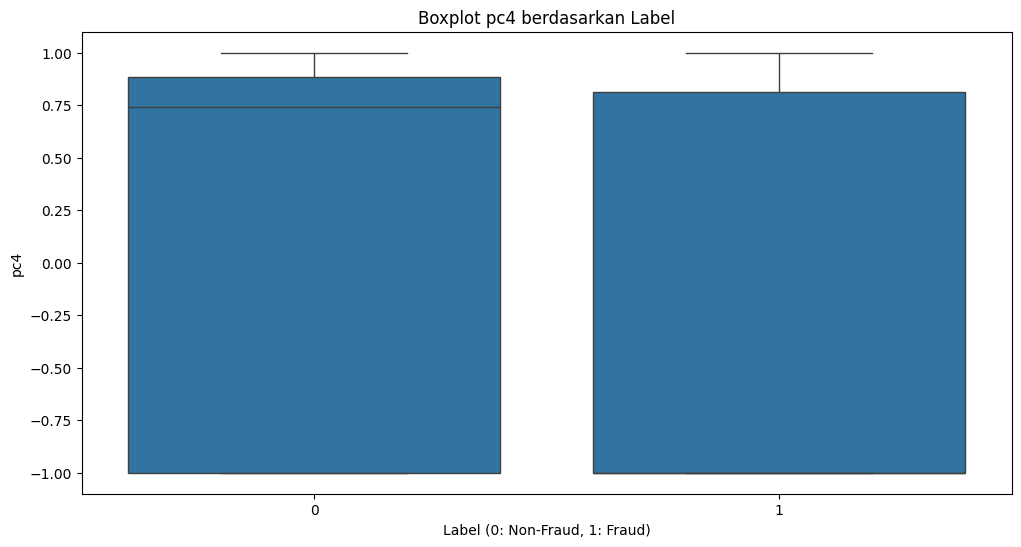

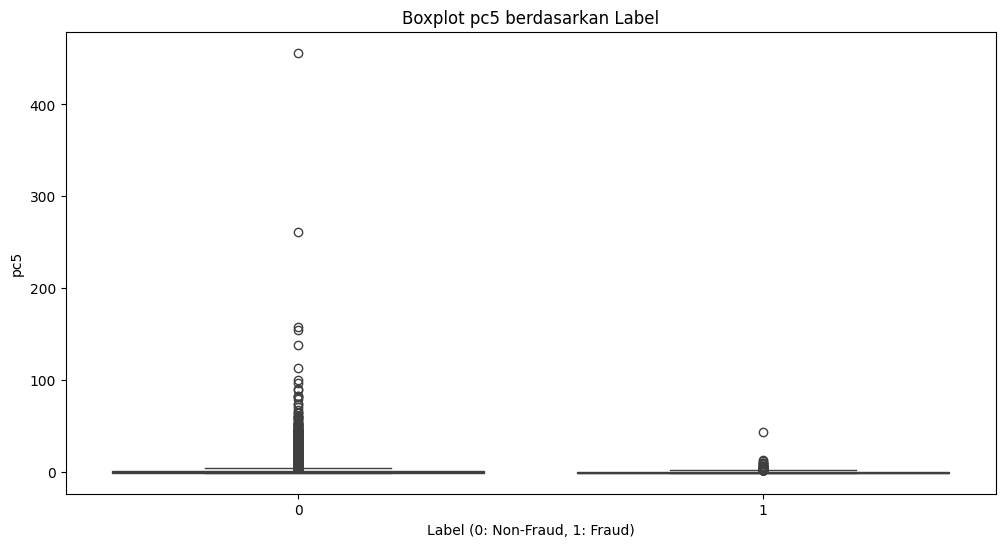

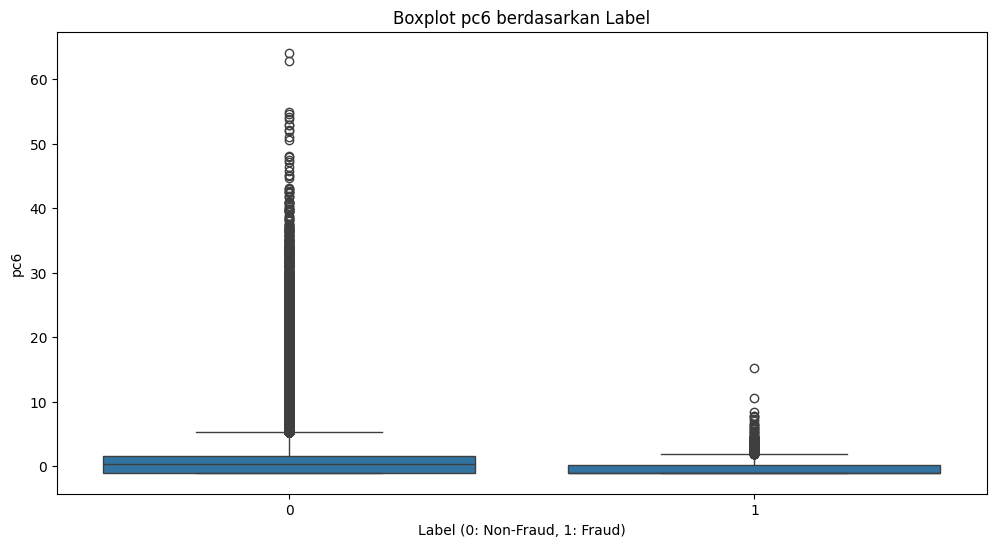

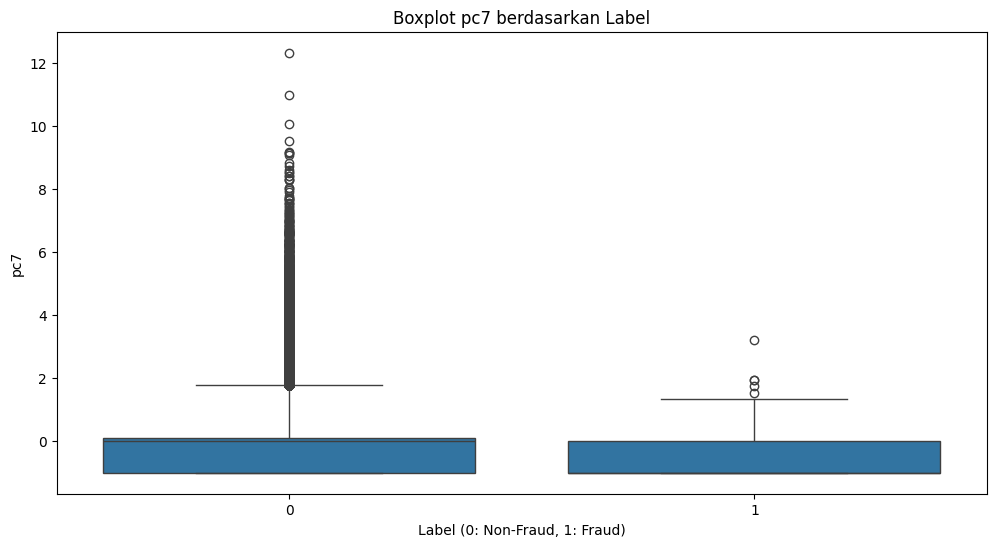

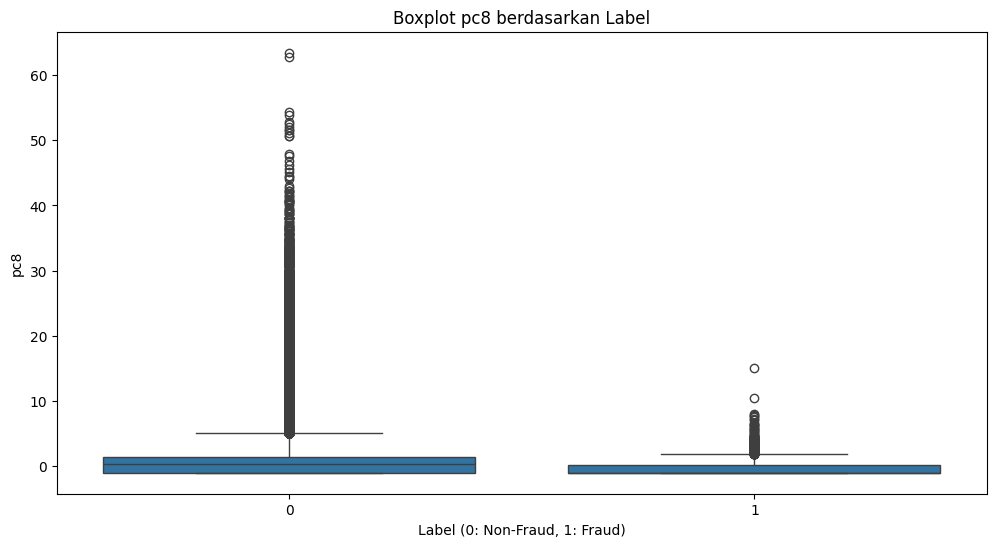

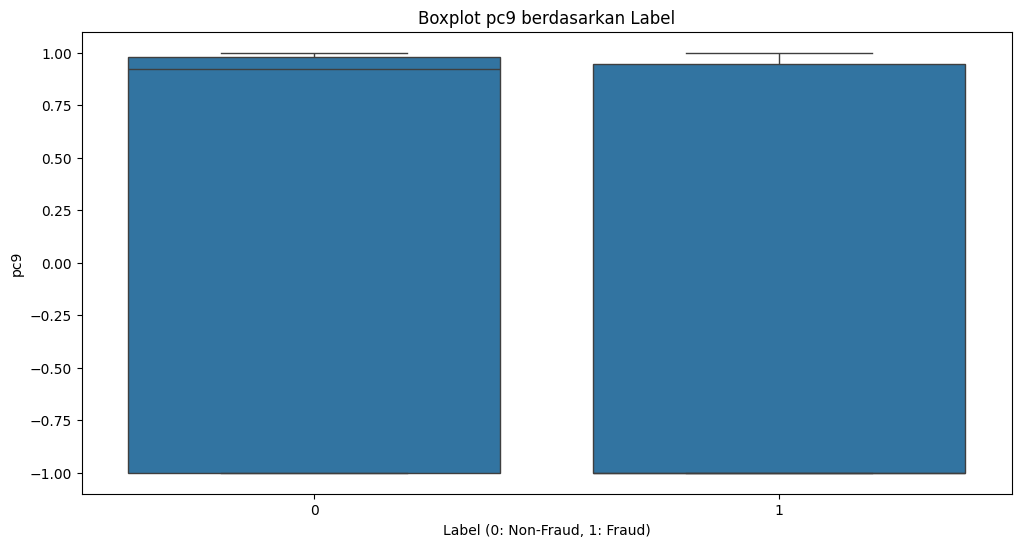

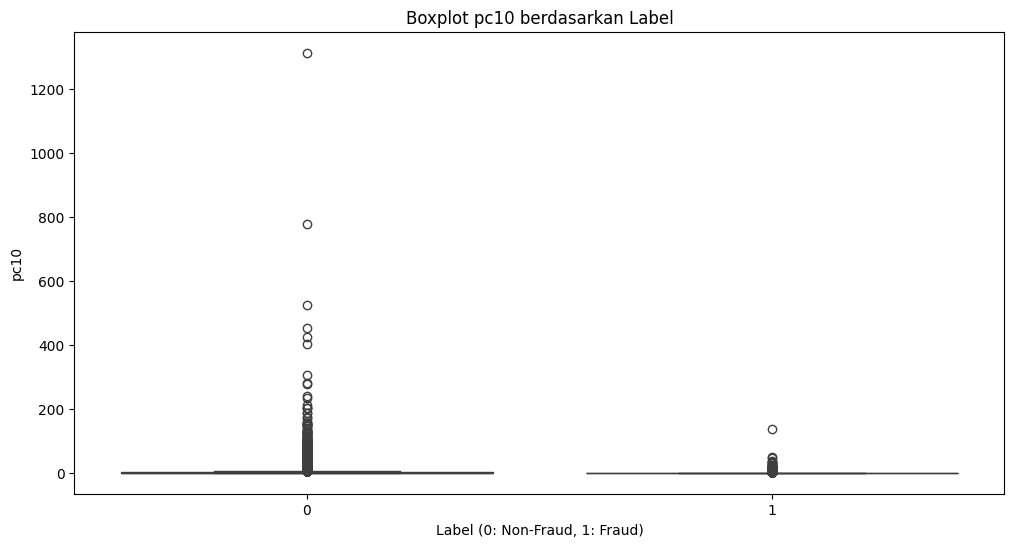

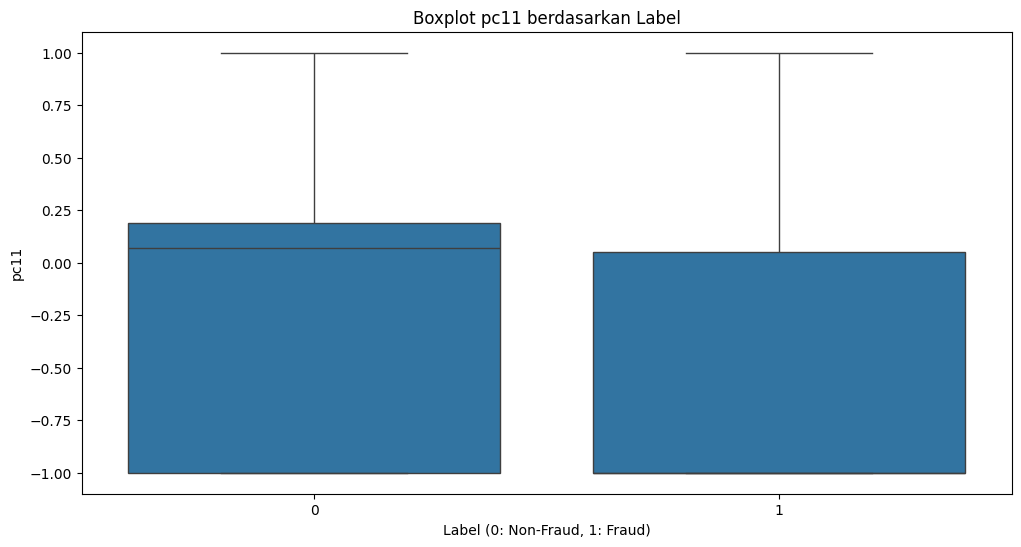

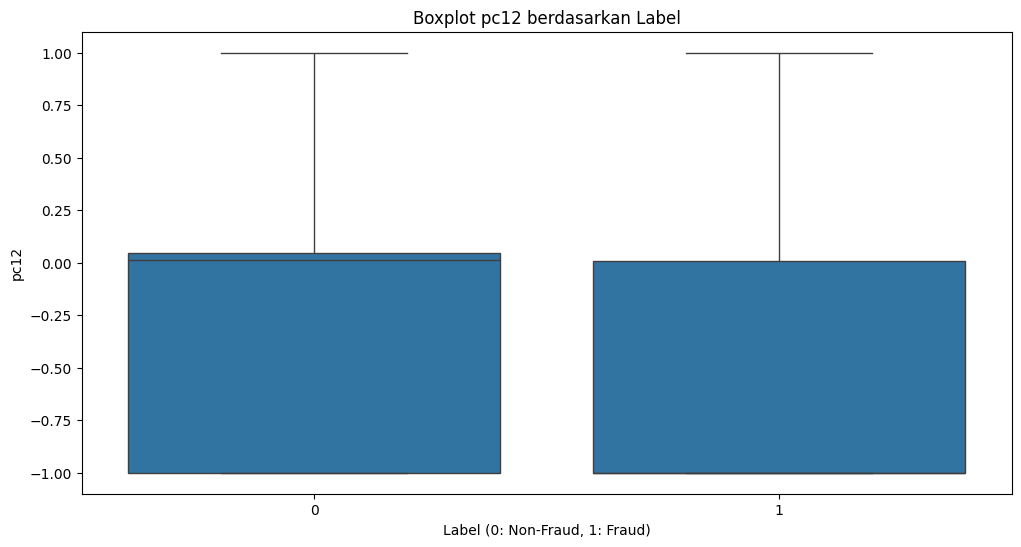

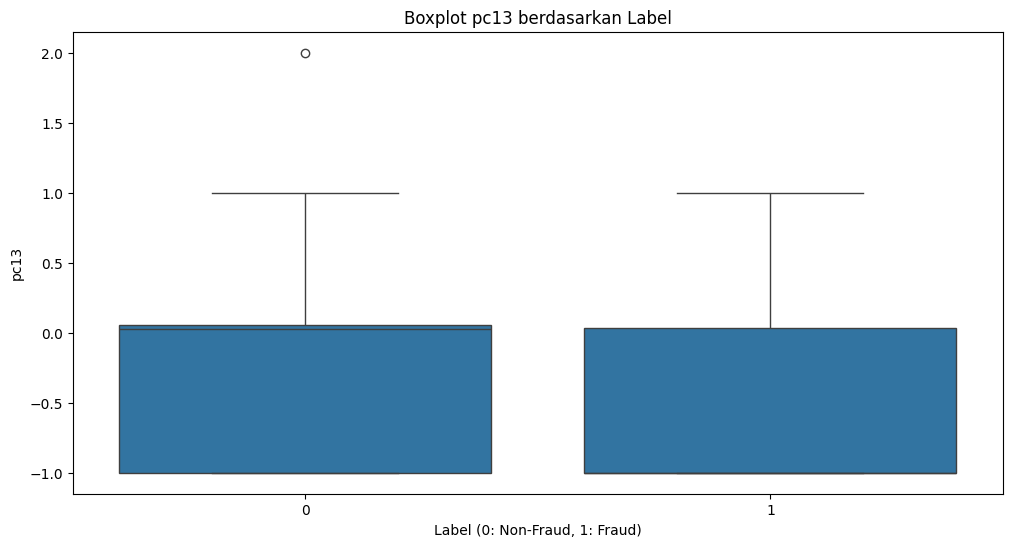

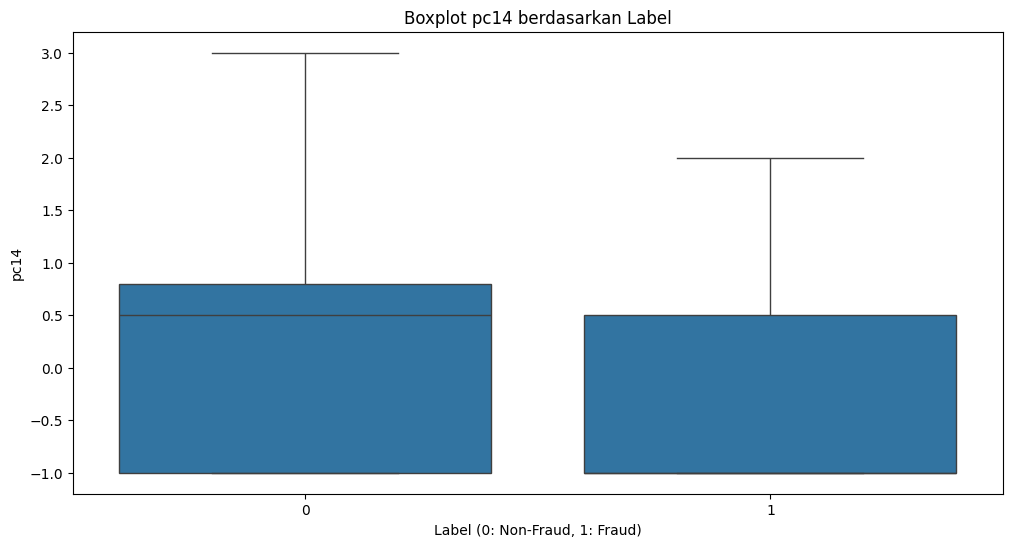

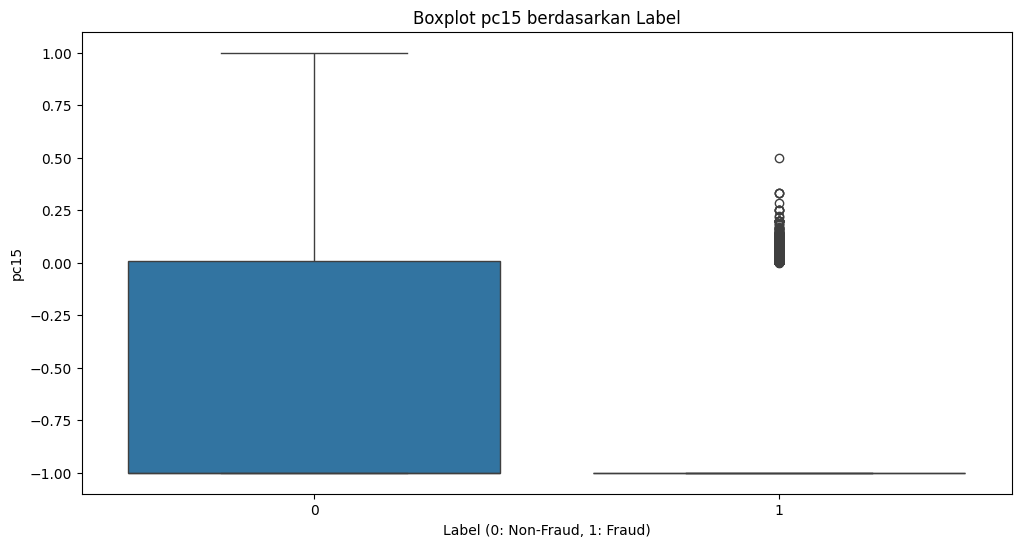

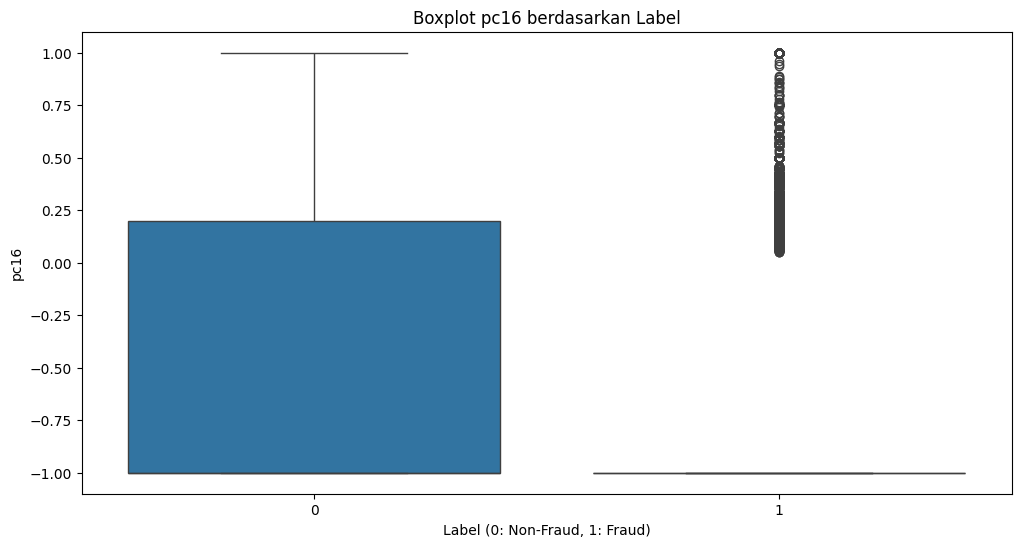

In [ ]:
# detect outlier
def plot_boxplot(feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y=feature, data=train)
    plt.title(f'Boxplot {feature} berdasarkan Label')
    plt.xlabel('Label (0: Non-Fraud, 1: Fraud)')
    plt.ylabel(feature)
    plt.show()

for feature in train.columns[1:-1]:
    plot_boxplot(feature)

Detecting outliers in the training dataset by creating a boxplot for each feature based on the label (0 for Non-Fraud and 1 for Fraud). There are numerous outliers in pc2, pc3, pc5, pc6, pc7, pc8, pc10, pc15, and pc16.

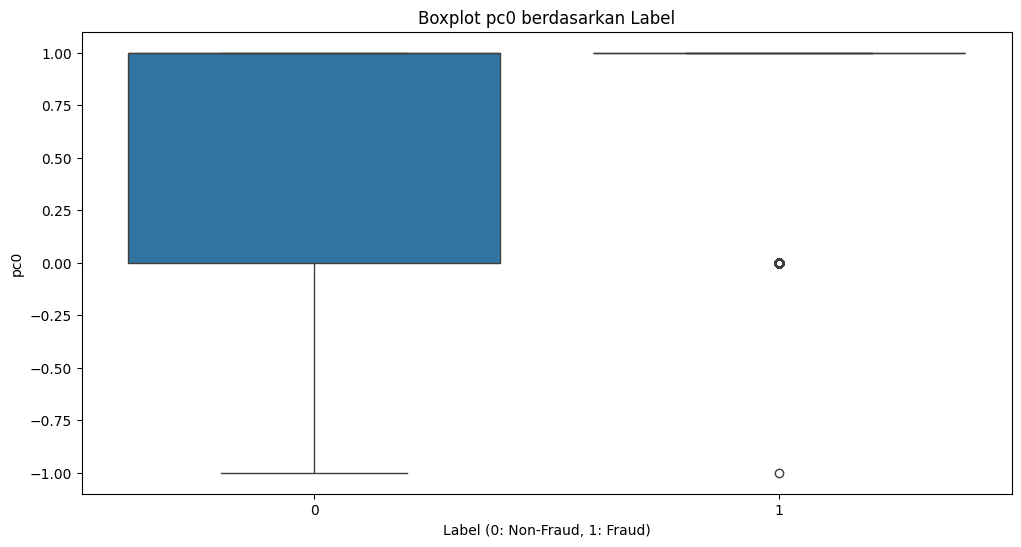

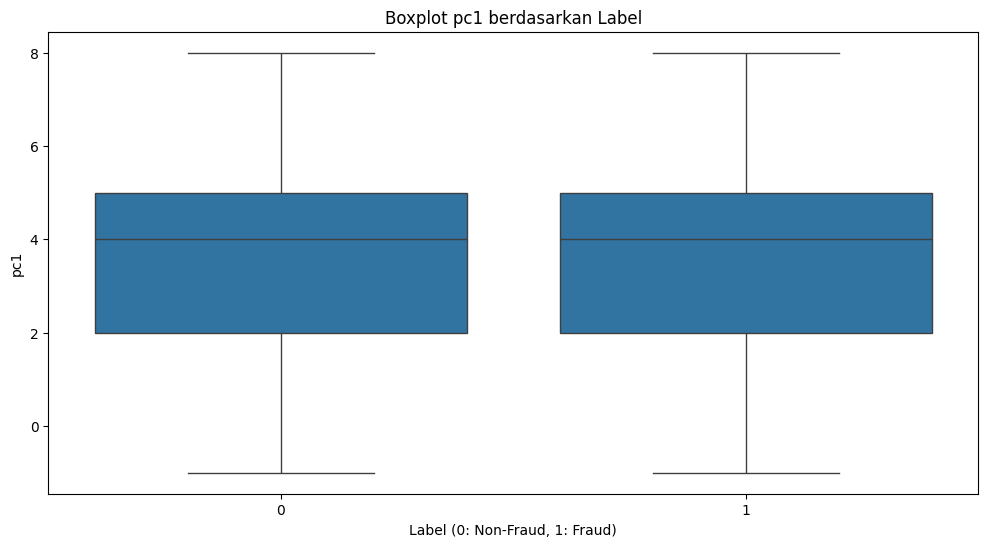

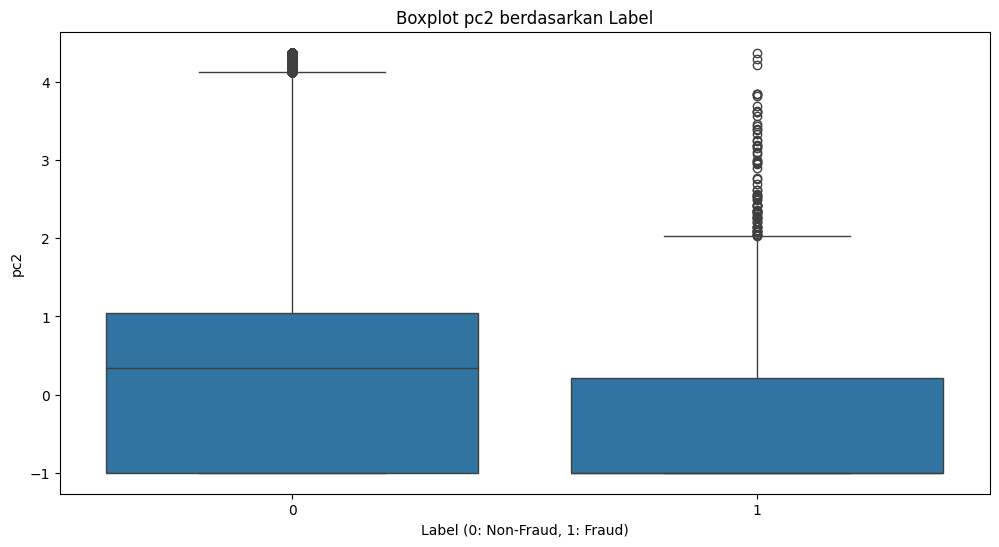

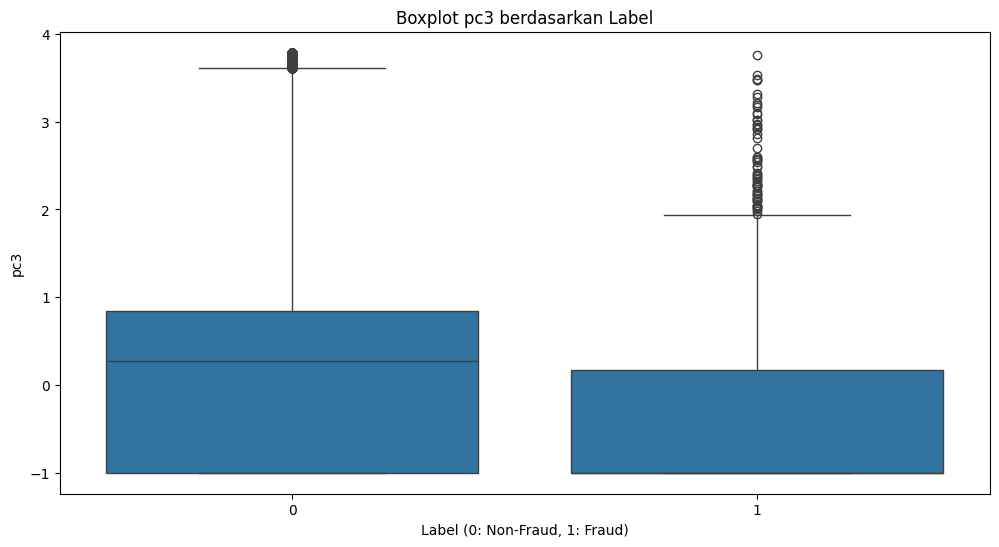

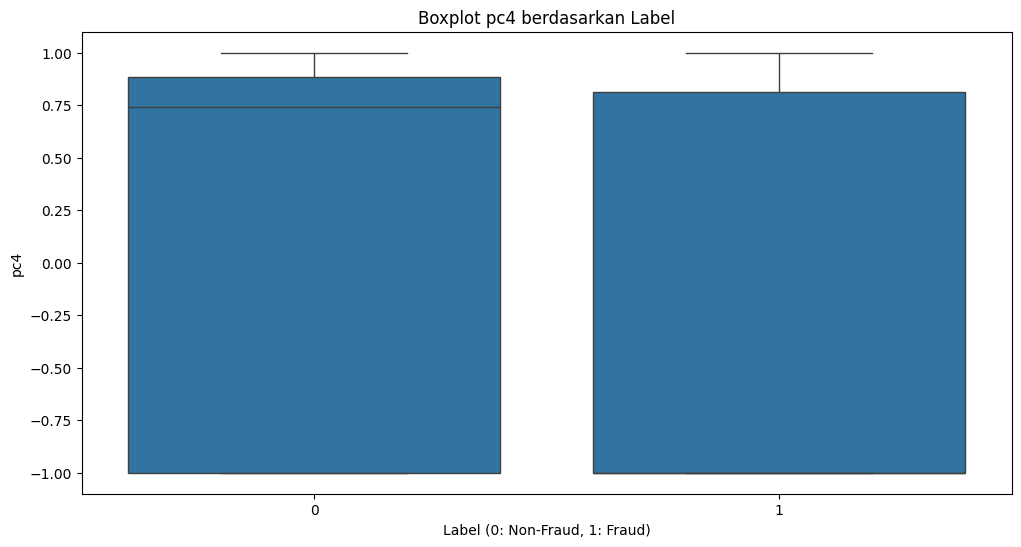

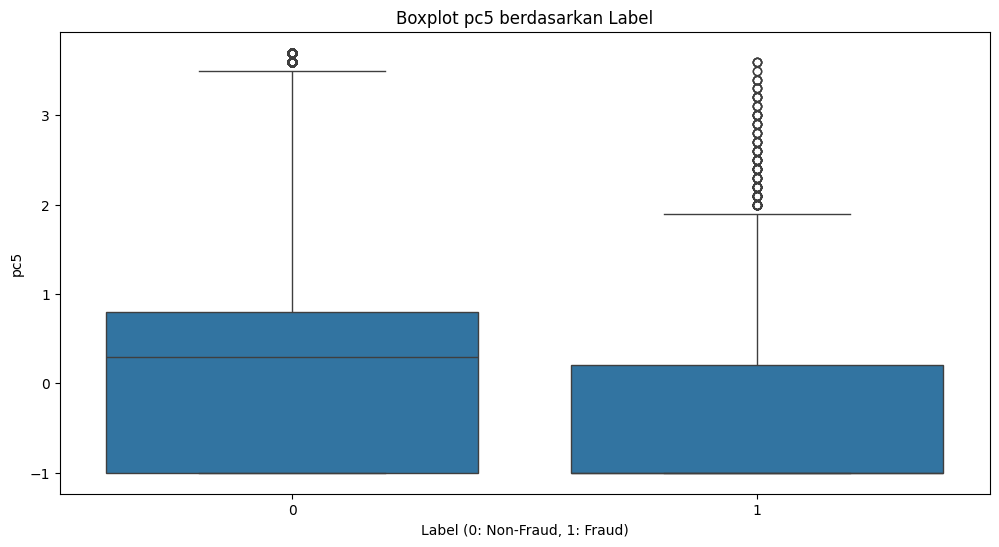

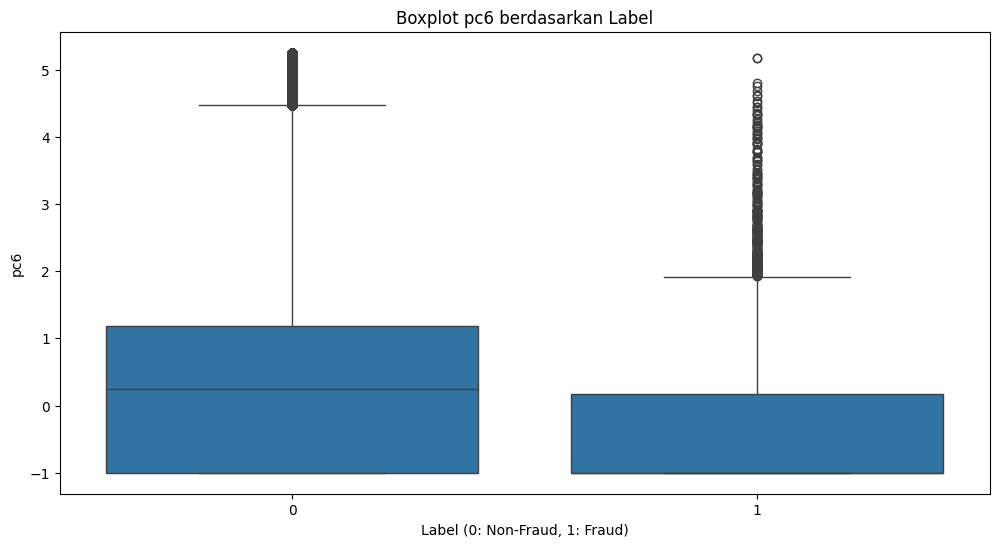

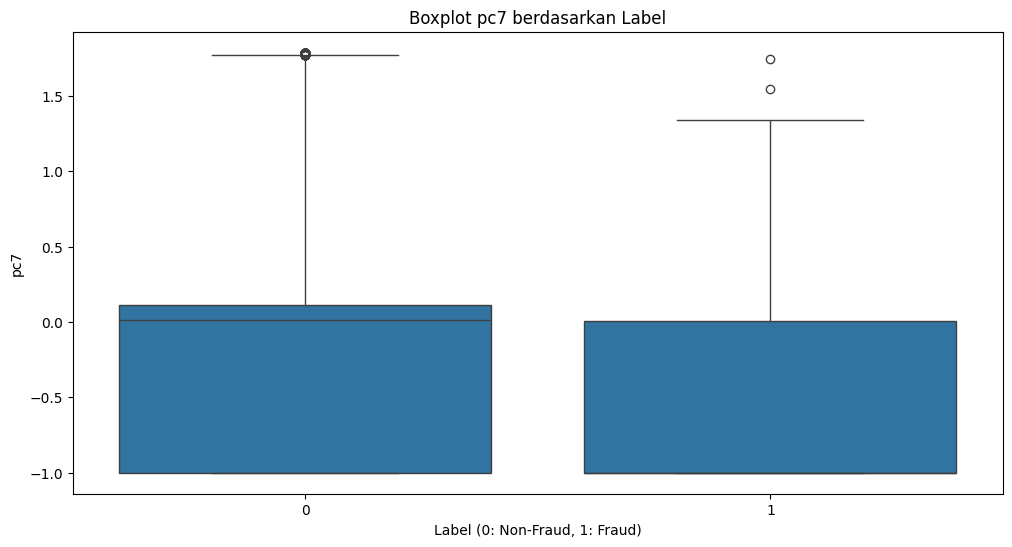

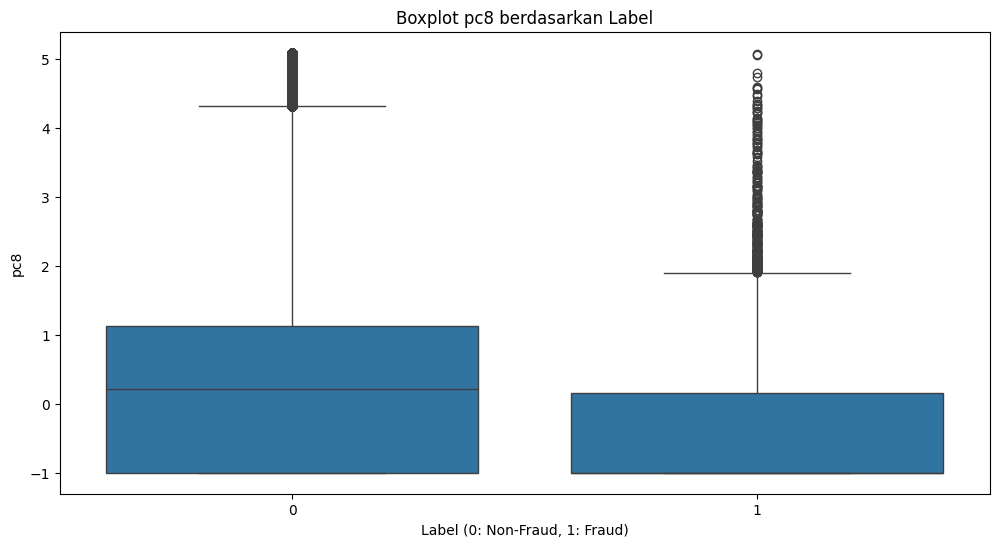

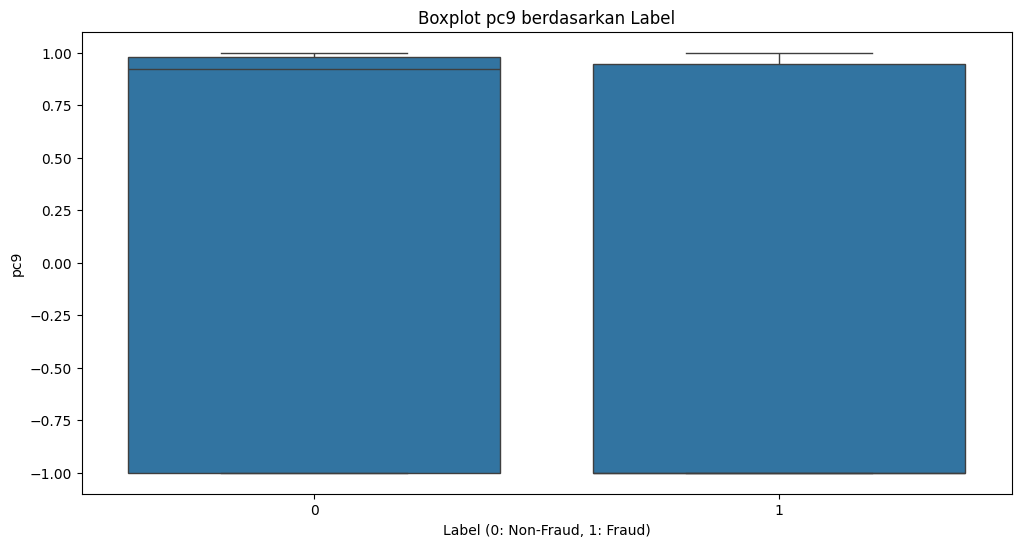

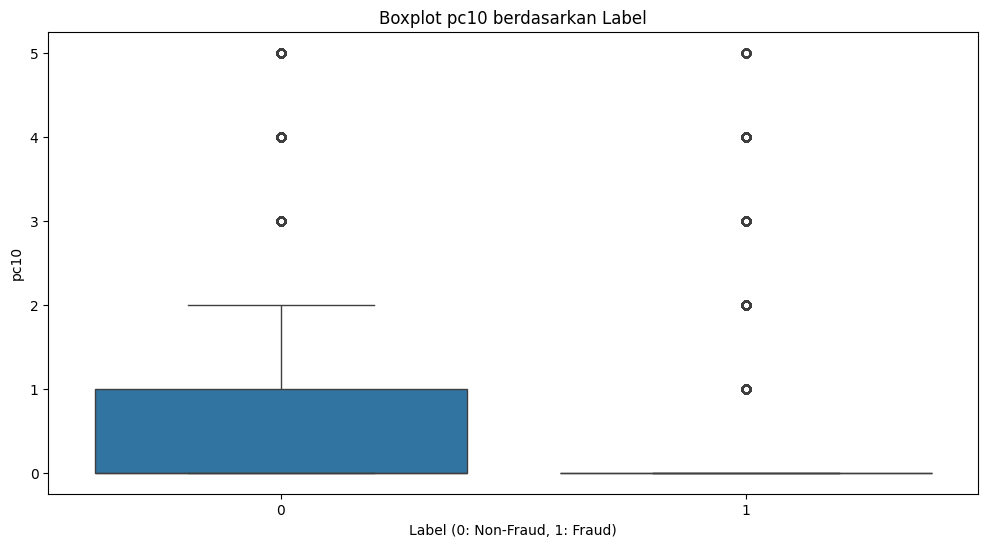

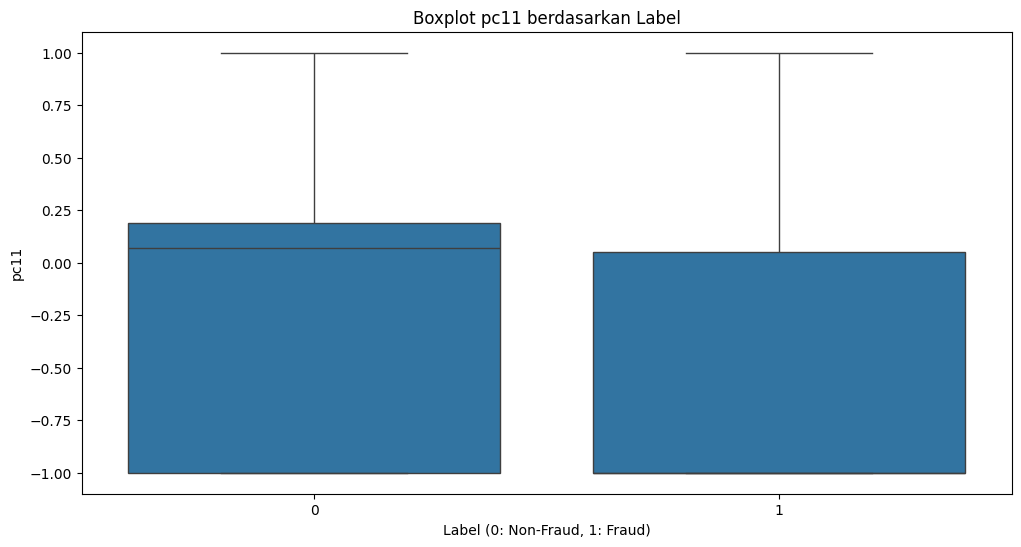

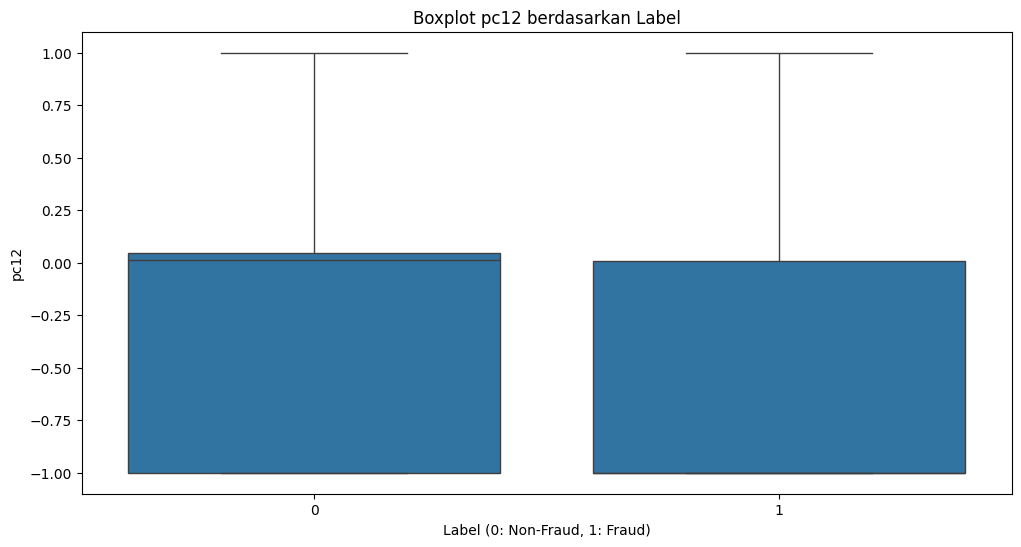

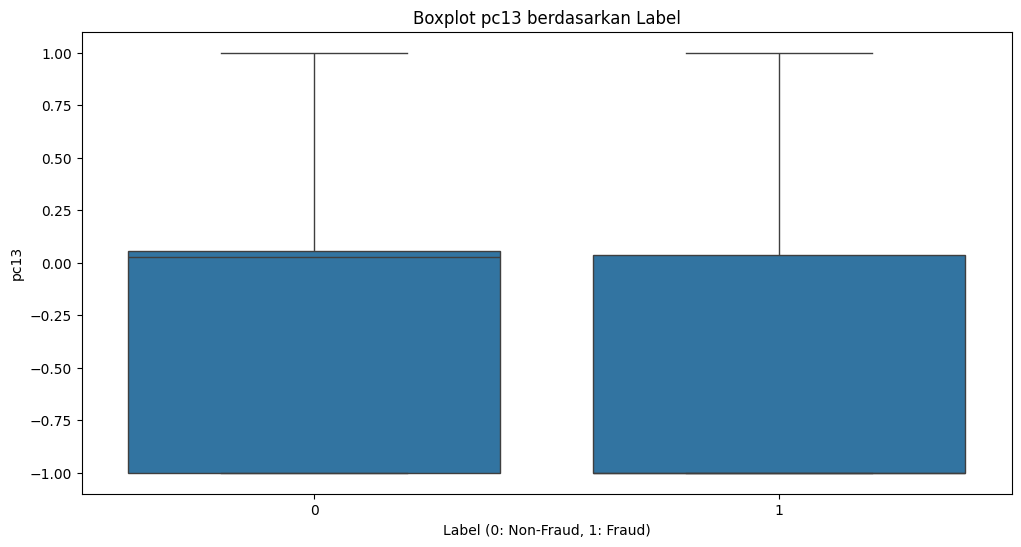

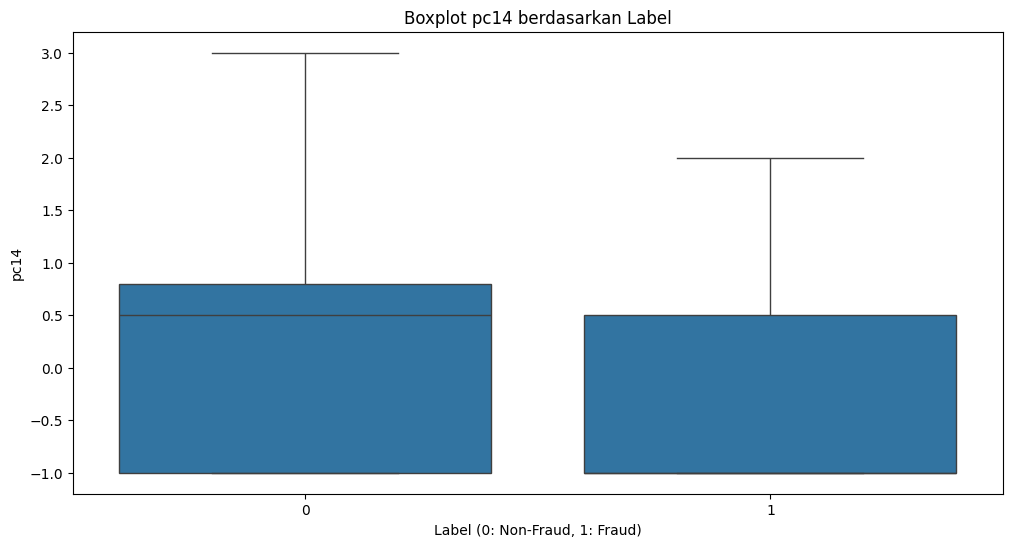

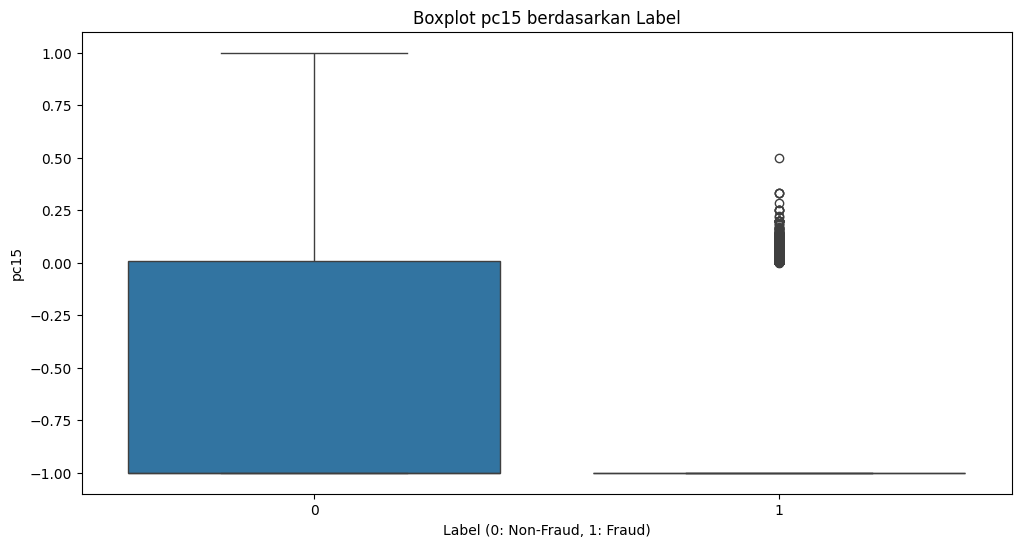

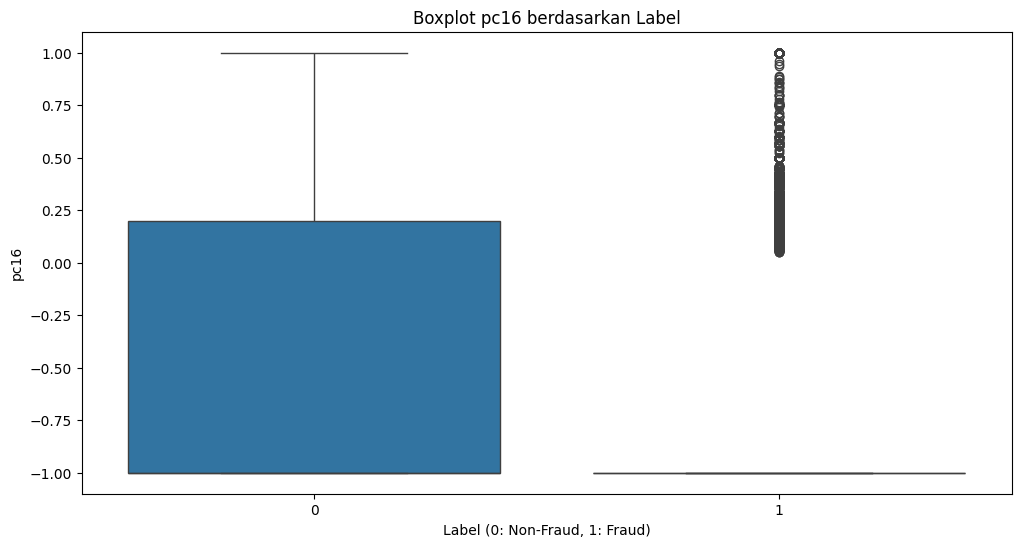

In [ ]:
# Fungsi untuk menghapus outlier menggunakan metode IQR
def remove_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Fungsi untuk membuat boxplot dari setiap fitur
def plot_boxplot(df, feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Boxplot {feature} berdasarkan Label')
    plt.xlabel('Label (0: Non-Fraud, 1: Fraud)')
    plt.ylabel(feature)
    plt.show()

# Perulangan untuk membuat boxplot untuk setiap fitur kecuali kolom pertama dan terakhir
for feature in train.columns[1:-1]:
    train_cleaned = remove_outliers_iqr(train, feature)
    plot_boxplot(train_cleaned, feature)

Removing outliers from the training dataset using the Interquartile Range (IQR) method

### Assesing data loan activities

In [ ]:
loan_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300999 entries, 0 to 4300998
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   user_id            int64
 1   reference_contact  int64
 2   loan_type          int64
 3   ts                 int64
dtypes: int64(4)
memory usage: 131.3 MB


In [ ]:
loan_activities.isna().sum()

user_id              0
reference_contact    0
loan_type            0
ts                   0
dtype: int64

There are no missing values in the loan_activity dataset

In [ ]:
print("Number of duplicate data: ", loan_activities.duplicated().sum())

Number of duplicate data:  0


There are no duplicate data in the loan_activity dataset

In [ ]:
loan_activities.describe()

,user_id,reference_contact,loan_type,ts
count,4.300999e+06,4.300999e+06,4.300999e+06,4.300999e+06
mean,1.850565e+06,1.849301e+06,5.104953e+00,4.093275e+02
std,1.068463e+06,1.068566e+06,2.205495e+00,2.222010e+02
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,9.249810e+05,9.229035e+05,4.000000e+00,2.260000e+02
50%,1.849778e+06,1.849514e+06,5.000000e+00,4.120000e+02
75%,2.776584e+06,2.775052e+06,6.000000e+00,5.820000e+02
max,3.700548e+06,3.700549e+06,1.100000e+01,8.210000e+02


In [ ]:
loan_activities['loan_type'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

There are 11 loan types (loan_type)

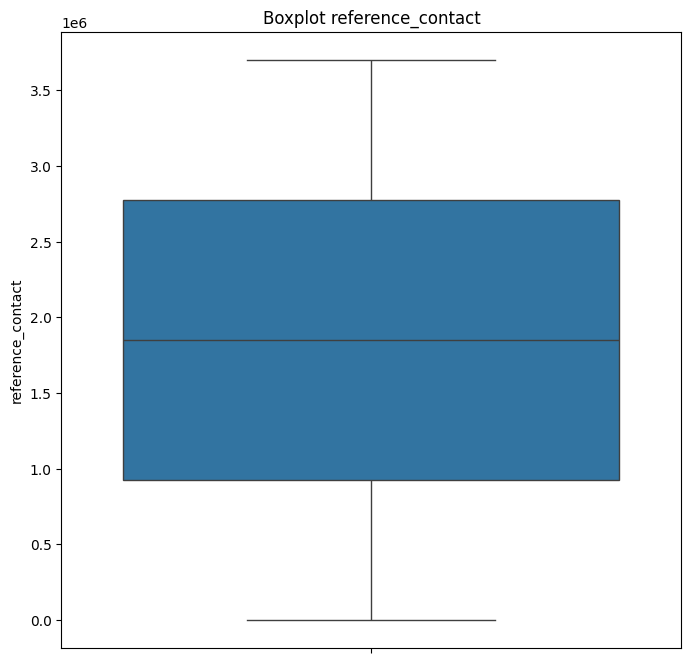

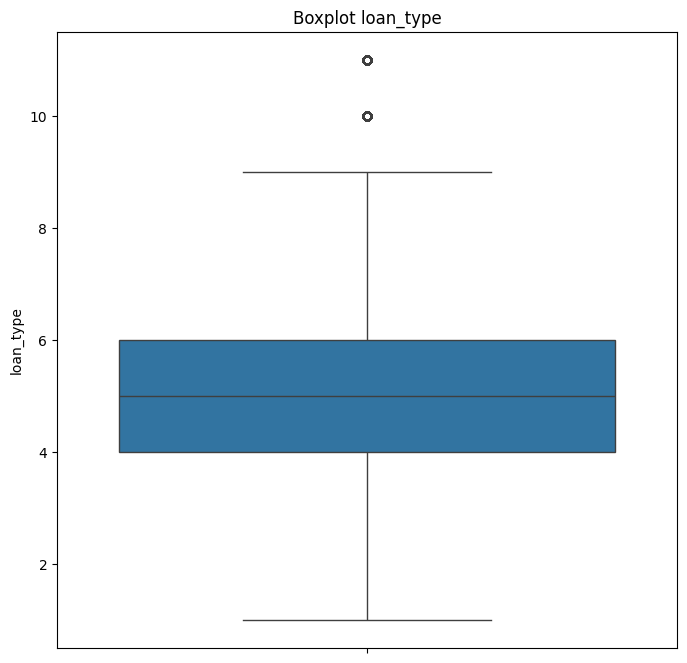

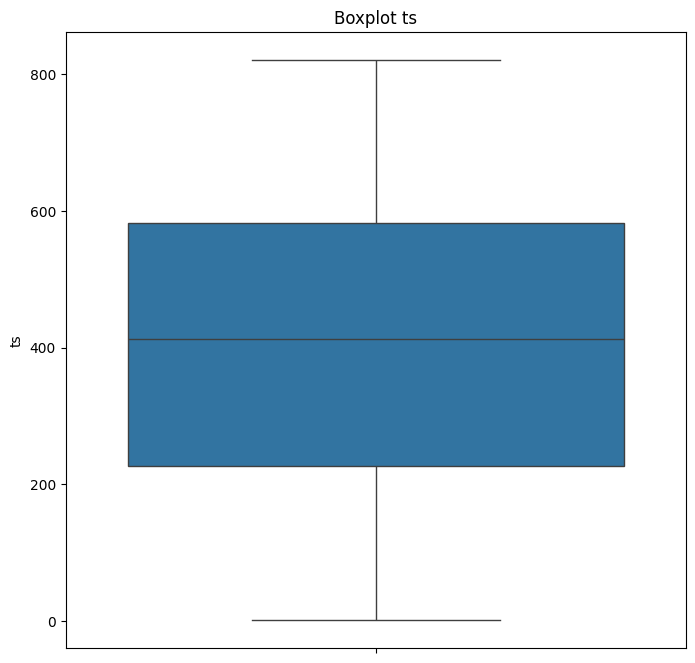

In [ ]:
# detect outlier
def plot(feature):
  plt.figure(figsize = (8,8))
  sns.boxplot(y = feature, data = loan_activities)
  plt.title(f'Boxplot {feature}')
  plt.show

for feature in loan_activities.columns[1:]:
  plot(feature)

Detecting outliers in the loan_activities dataset by creating boxplots for each feature (column).

### Assesing Data non-borrower user

In [ ]:
non_borrower_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   user_id  1048575 non-null  int64  
 1   pc0      1048575 non-null  int64  
 2   pc1      1048575 non-null  int64  
 3   pc2      1048575 non-null  float64
 4   pc3      1048575 non-null  float64
 5   pc4      1048575 non-null  float64
 6   pc5      1048575 non-null  float64
 7   pc6      1048575 non-null  float64
 8   pc7      1048575 non-null  float64
 9   pc8      1048575 non-null  float64
 10  pc9      1048575 non-null  float64
 11  pc10     1048575 non-null  int64  
 12  pc11     1048575 non-null  float64
 13  pc12     1048575 non-null  float64
 14  pc13     1048575 non-null  float64
 15  pc14     1048575 non-null  float64
 16  pc15     1048575 non-null  float64
 17  pc16     1048575 non-null  float64
dtypes: float64(14), int64(4)
memory usage: 144.0 MB


there are different data types for columns pc0, pc1, and pc10

In [ ]:
non_borrower_user.isna().sum()

user_id    0
pc0        0
pc1        0
pc2        0
pc3        0
pc4        0
pc5        0
pc6        0
pc7        0
pc8        0
pc9        0
pc10       0
pc11       0
pc12       0
pc13       0
pc14       0
pc15       0
pc16       0
dtype: int64

No missing values in non_borrower user dataset

In [ ]:
print("Number of duplicate data: ", non_borrower_user.duplicated().sum())

Number of duplicate data:  0


No duplication of data in the non borrower user dataset

In [ ]:
non_borrower_user.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,7.845509e+05,3.887829e-01,2.764622e+00,-4.025661e-01,-4.321563e-01,-3.165213e-01,-4.604148e-01,-3.464219e-01,-6.442732e-01,-3.551684e-01,-2.855068e-01,4.385094e-01,-6.227477e-01,-6.537622e-01,-6.519266e-01,-4.526044e-01,-7.981312e-01,-7.348920e-01
std,4.526281e+05,8.221746e-01,2.870280e+00,9.388054e-01,8.878405e-01,9.028309e-01,9.240246e-01,1.042326e+00,5.216804e-01,1.027156e+00,9.418125e-01,1.587725e+00,5.432509e-01,4.967269e-01,5.023275e-01,8.340102e-01,4.069985e-01,5.439490e-01
min,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.925625e+05,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,7.851340e+05,1.000000e+00,3.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
75%,1.176676e+06,1.000000e+00,5.000000e+00,2.500000e-01,2.150000e-01,8.413886e-01,2.000000e-01,2.330000e-01,7.000000e-03,2.200000e-01,9.568528e-01,0.000000e+00,5.882353e-02,1.142857e-02,3.571429e-02,5.714286e-01,-1.000000e+00,-1.000000e+00
max,1.568298e+06,1.000000e+00,8.000000e+00,5.176500e+01,5.091500e+01,1.000000e+00,9.180000e+01,3.430200e+01,7.132000e+00,3.406400e+01,1.000000e+00,4.560000e+02,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00


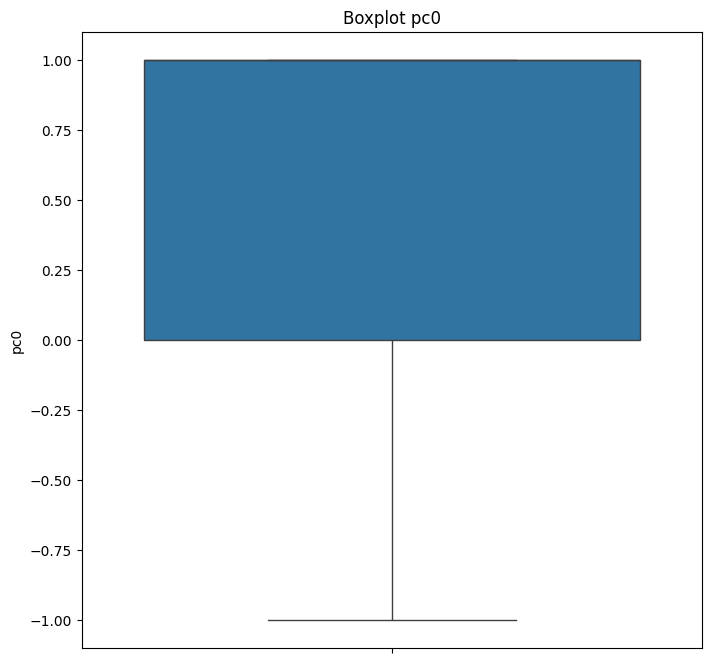

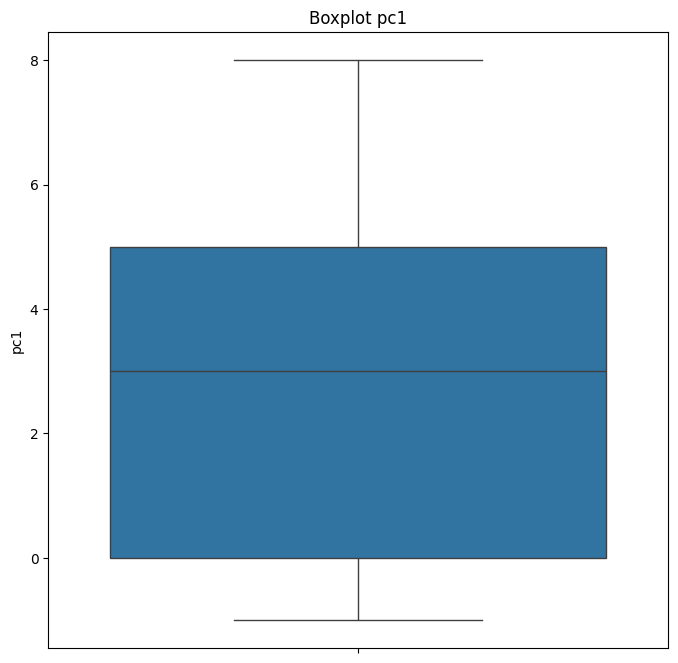

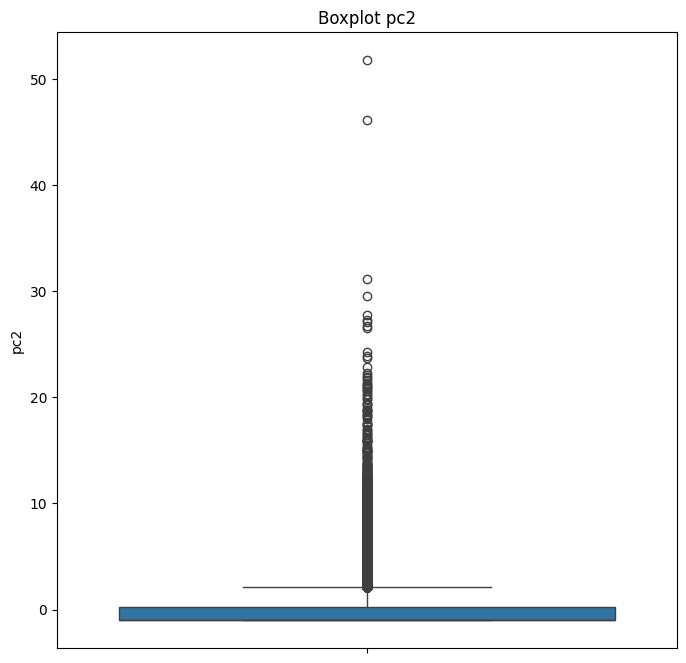

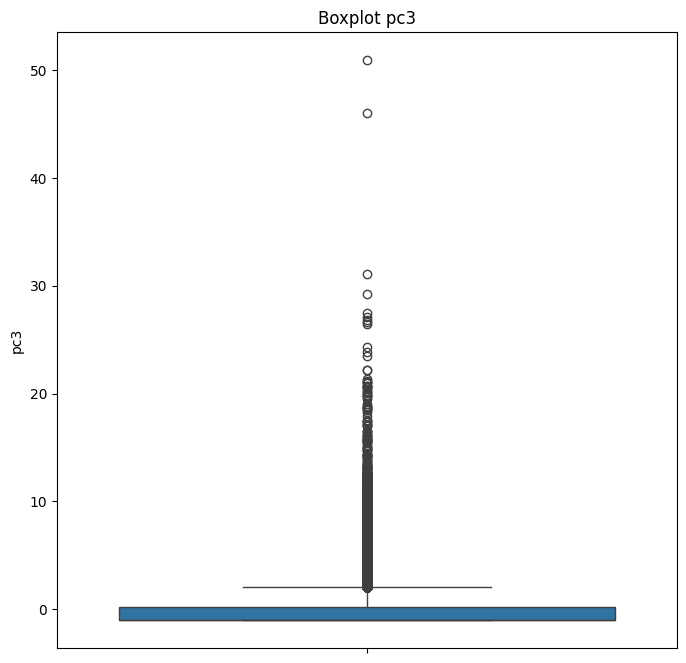

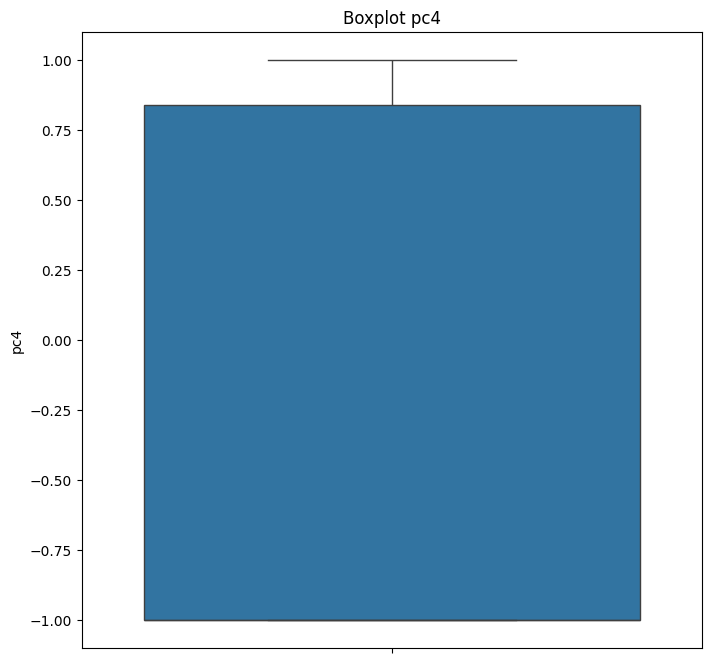

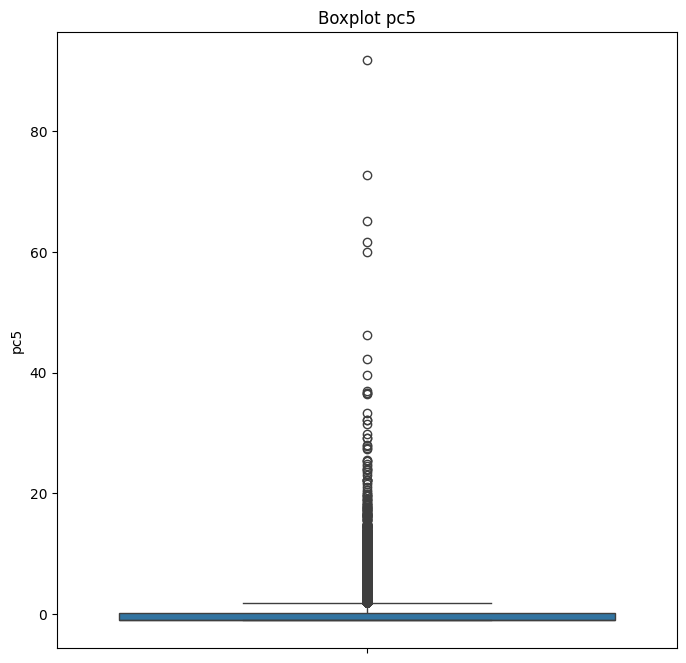

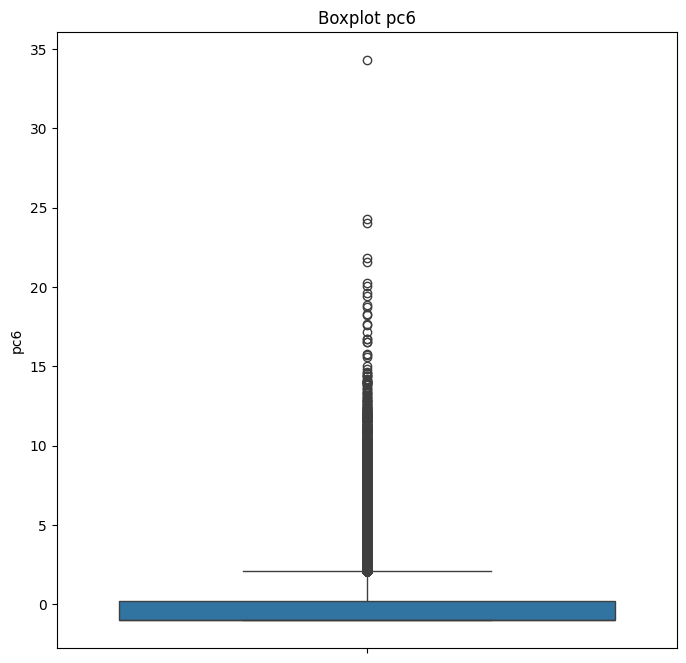

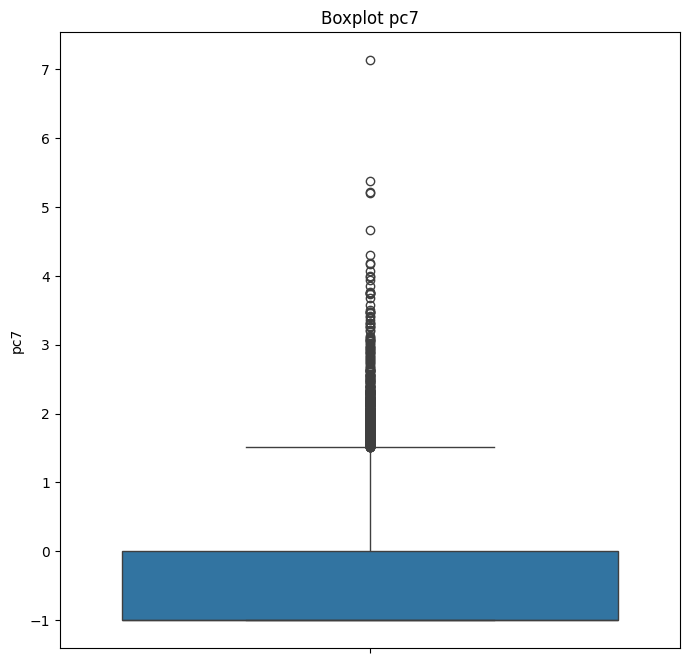

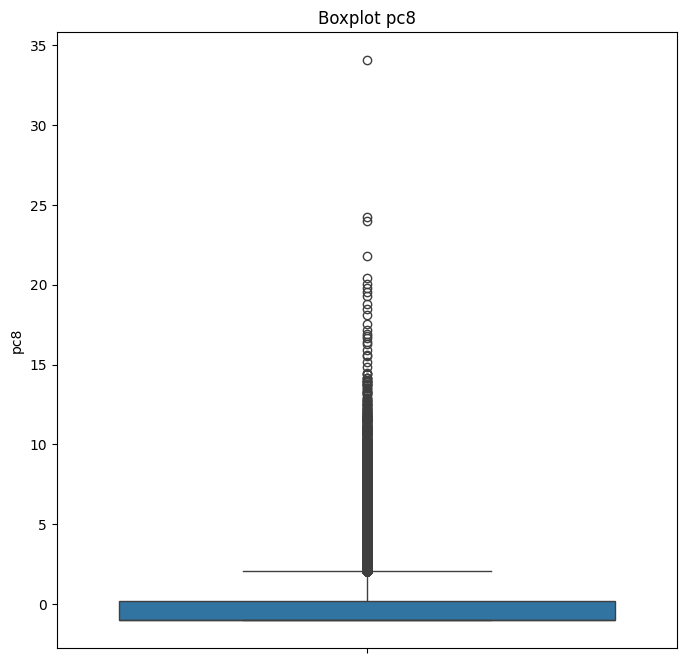

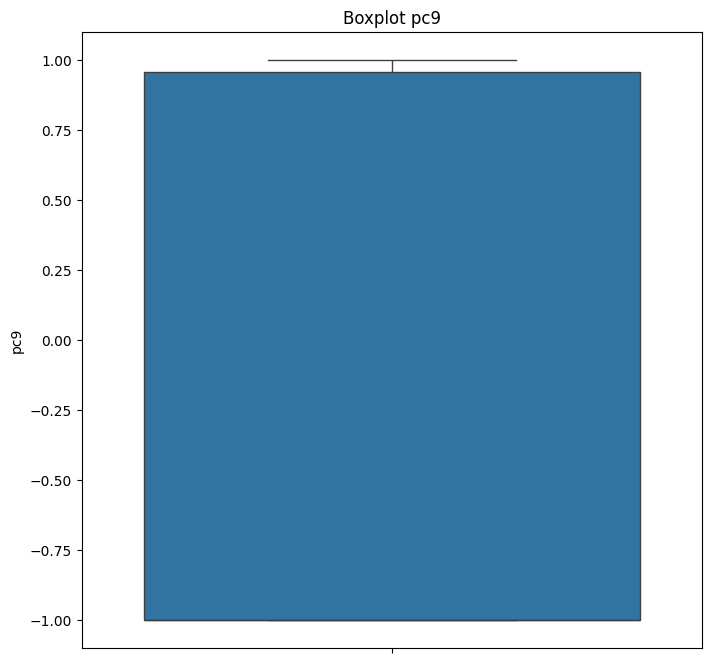

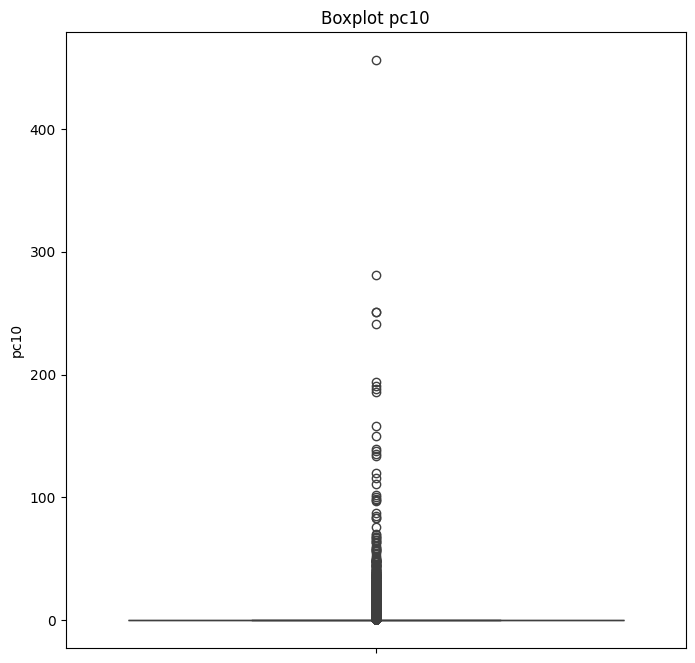

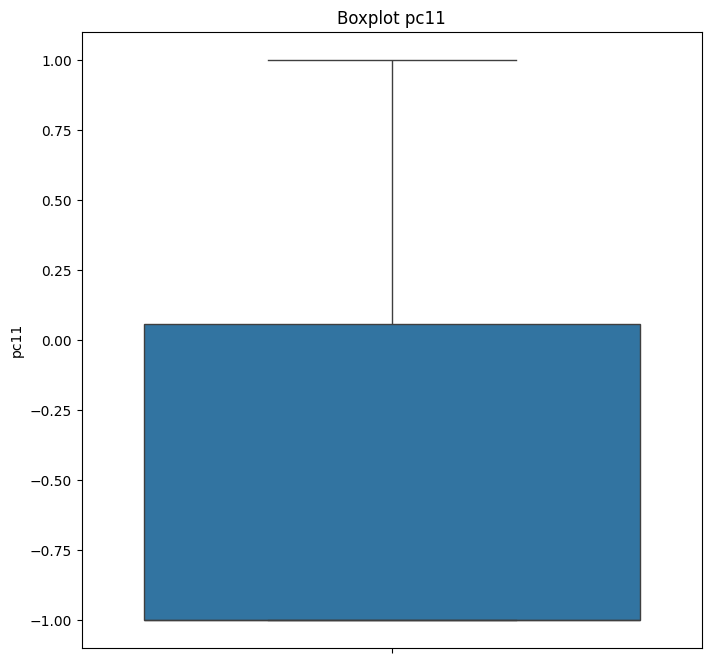

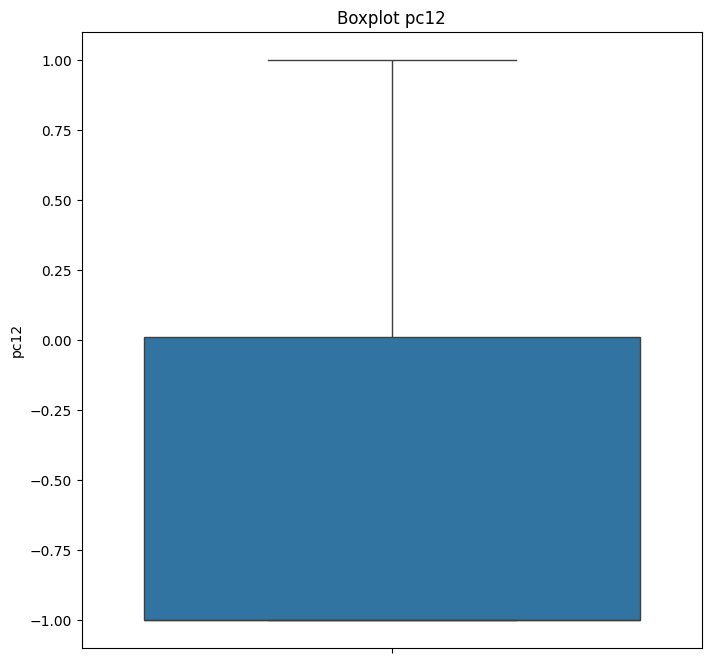

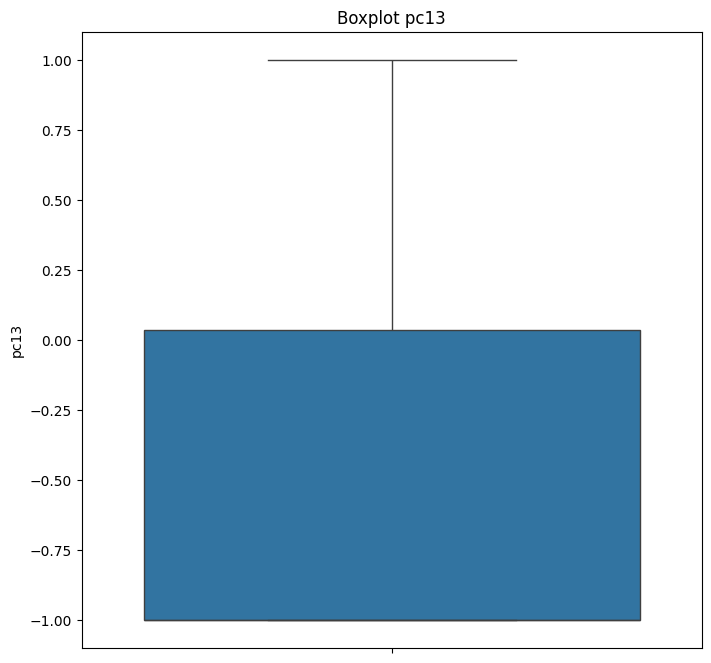

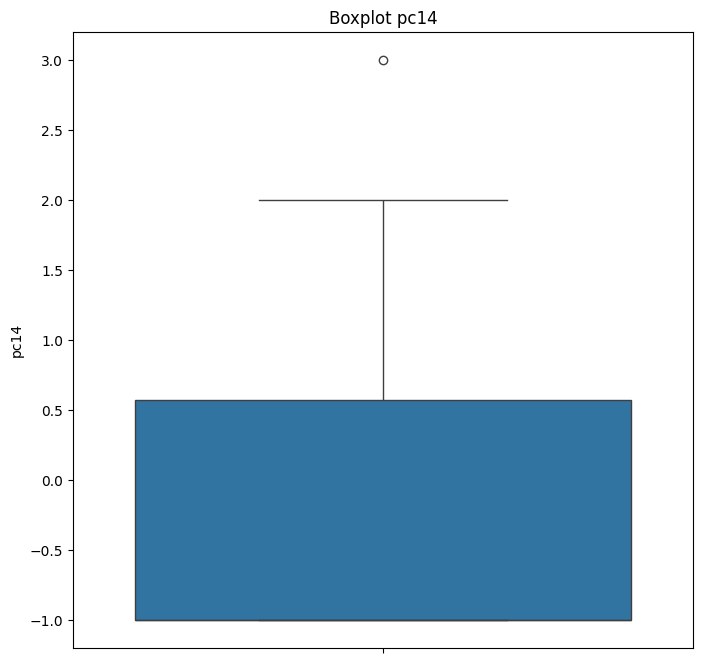

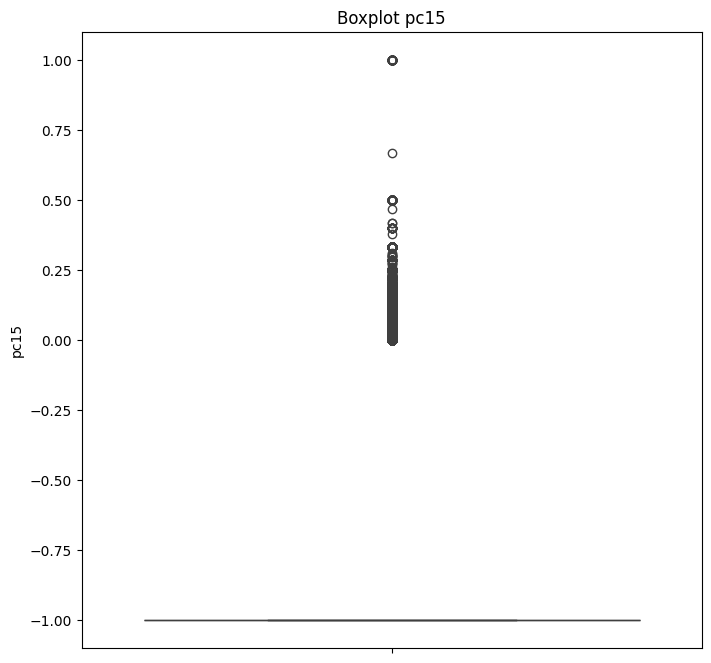

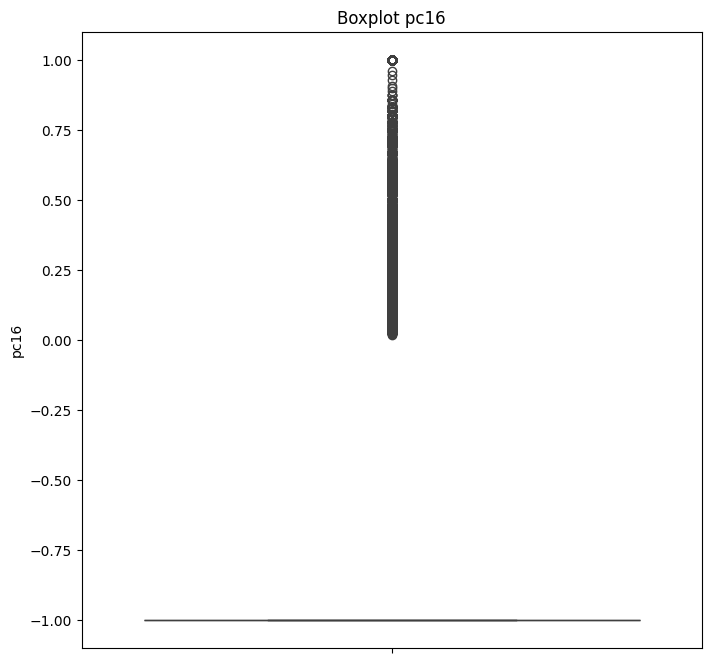

In [ ]:
# detect outlier
def plot(feature):
  plt.figure(figsize = (8,8))
  sns.boxplot(y = feature, data = non_borrower_user)
  plt.title(f'Boxplot {feature}')
  plt.show

for feature in non_borrower_user.columns[1:]:
  plot(feature)

Mendeteksi outlier pada dataset non_borrower_user dengan membuat boxplot untuk setiap fitur (kolom). Terdapat outlier pada pc2, pc3, pc5, pc6, pc7, pc8, pc10, pc14, pc15, dan pc16.

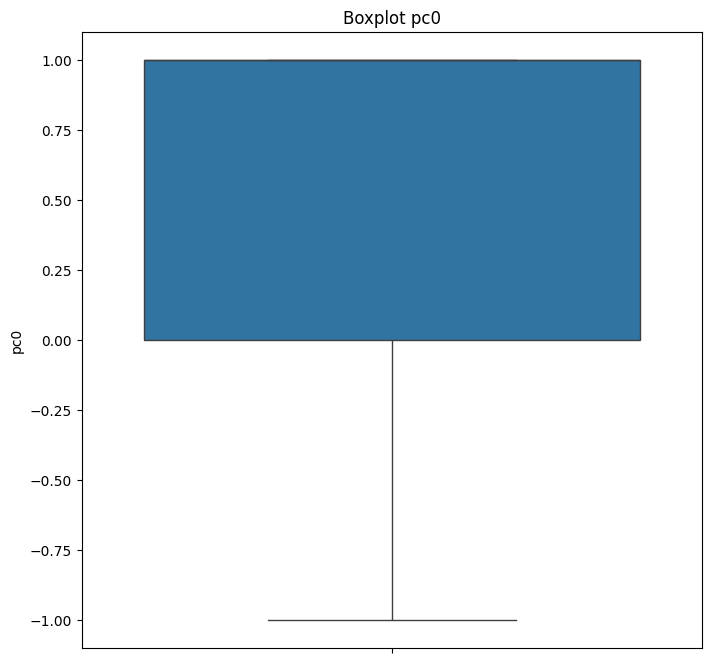

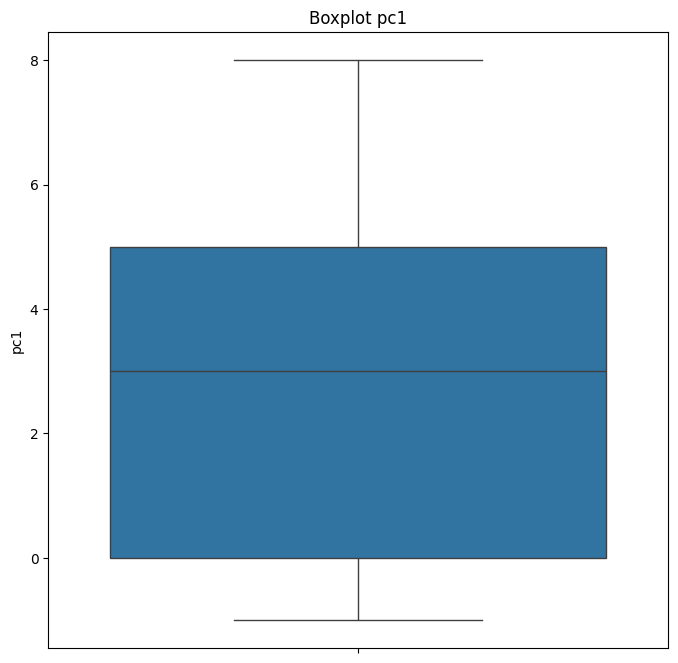

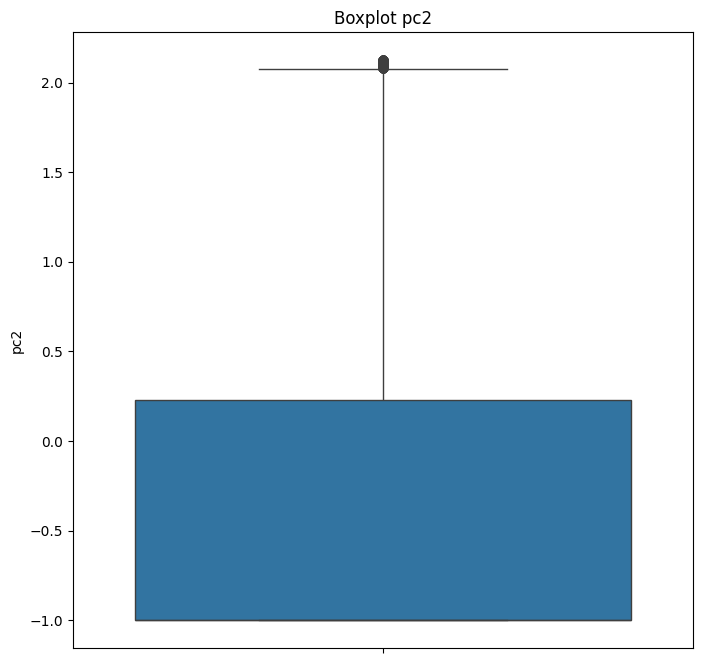

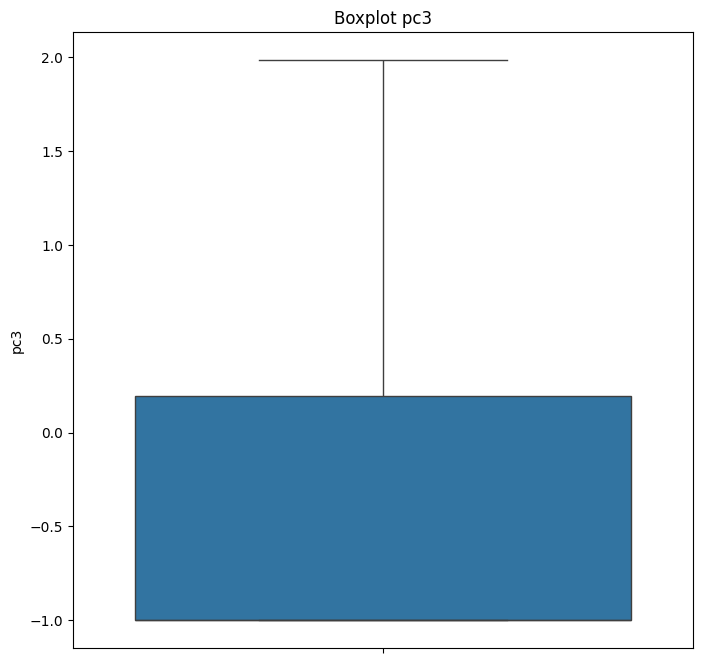

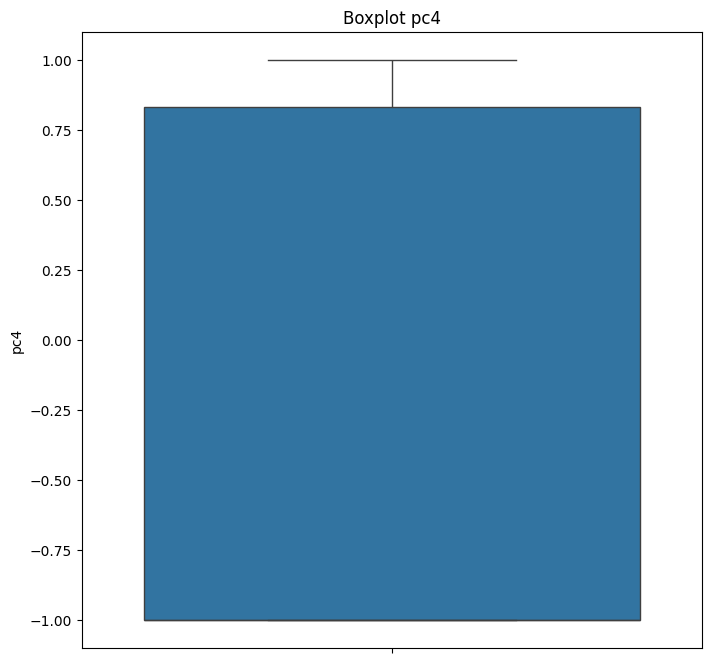

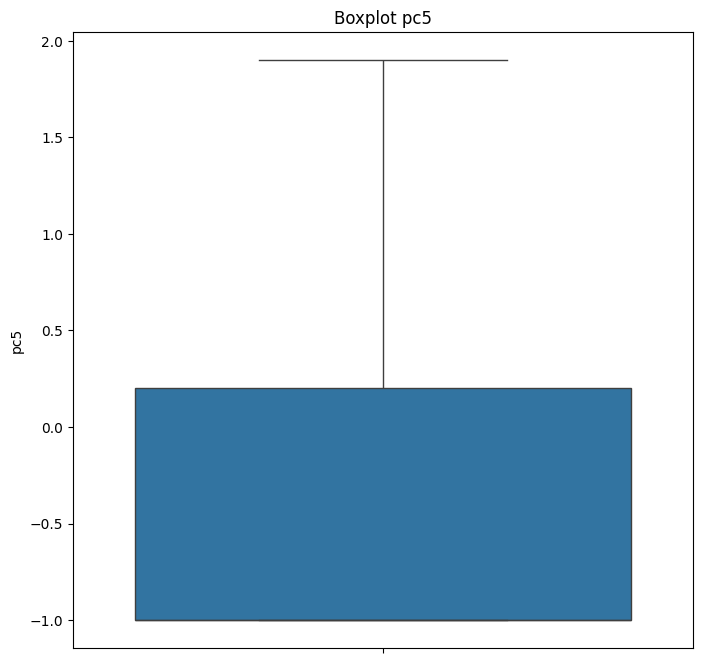

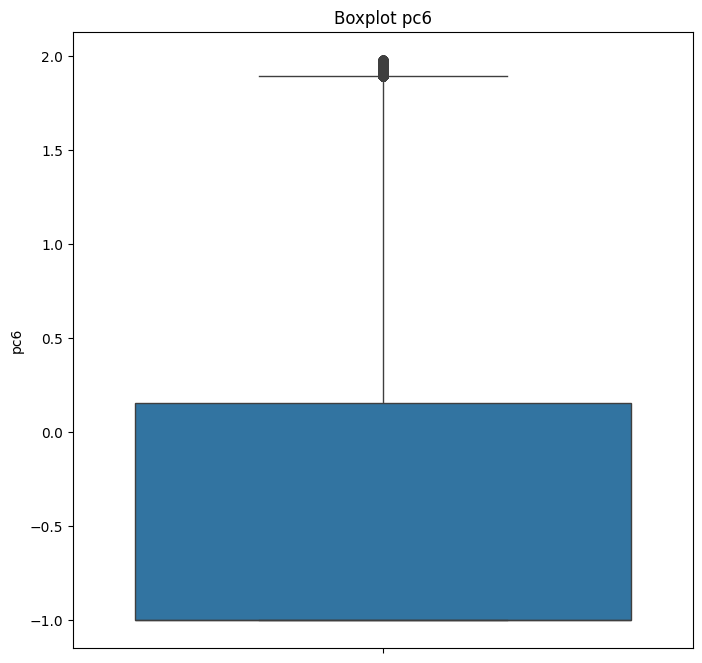

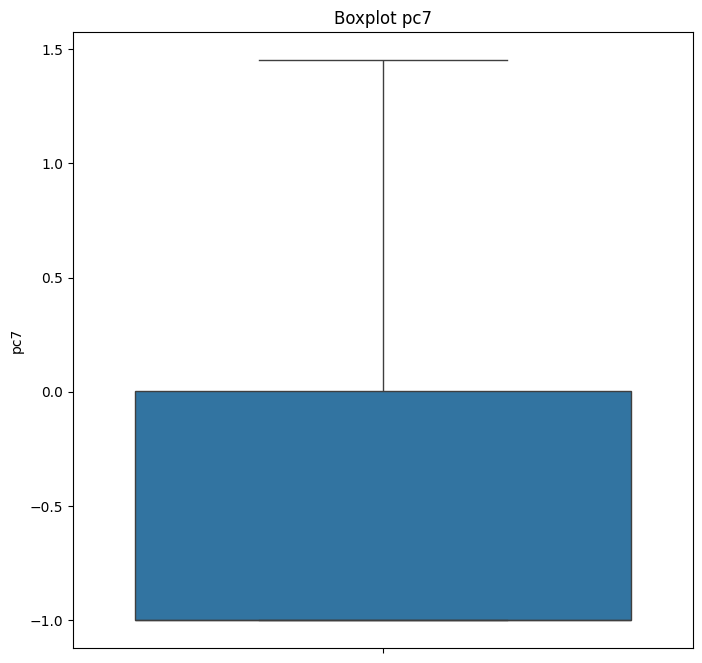

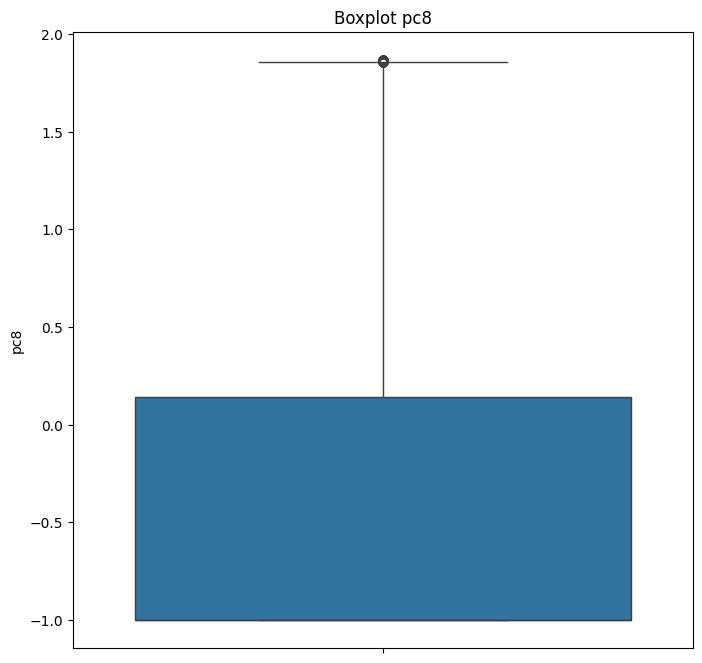

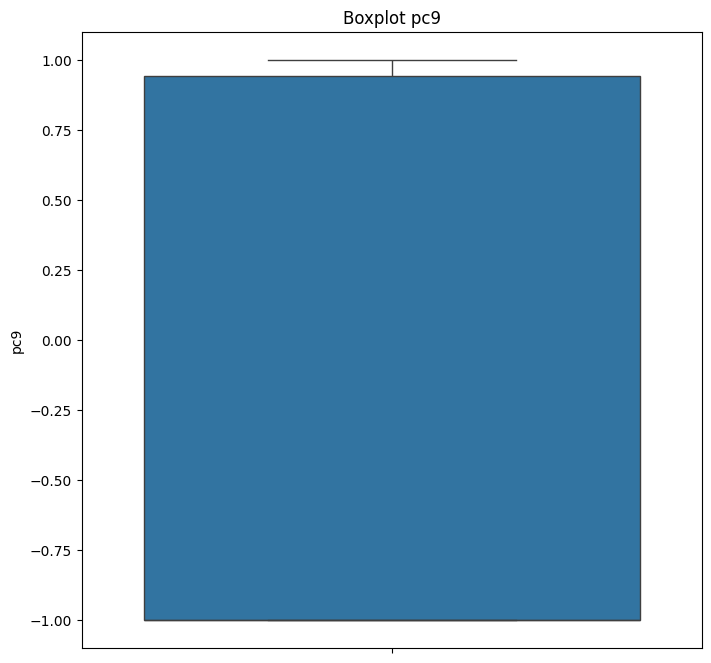

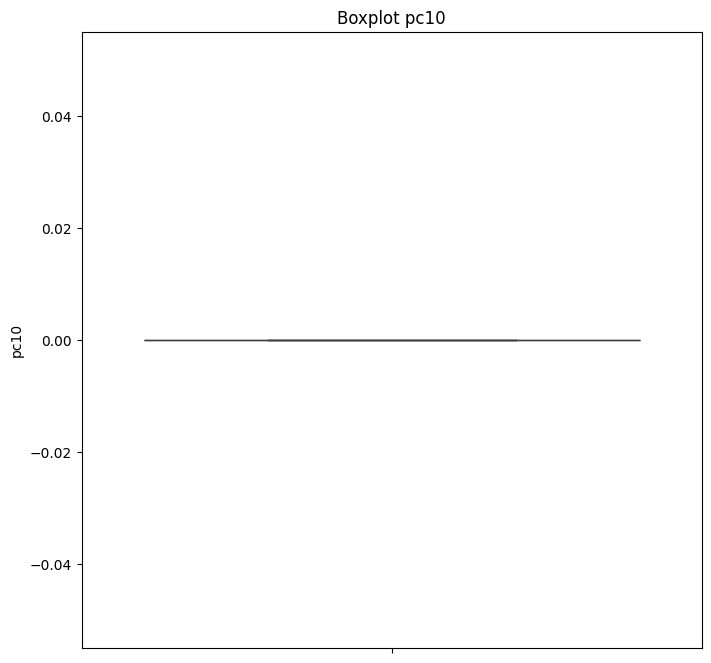

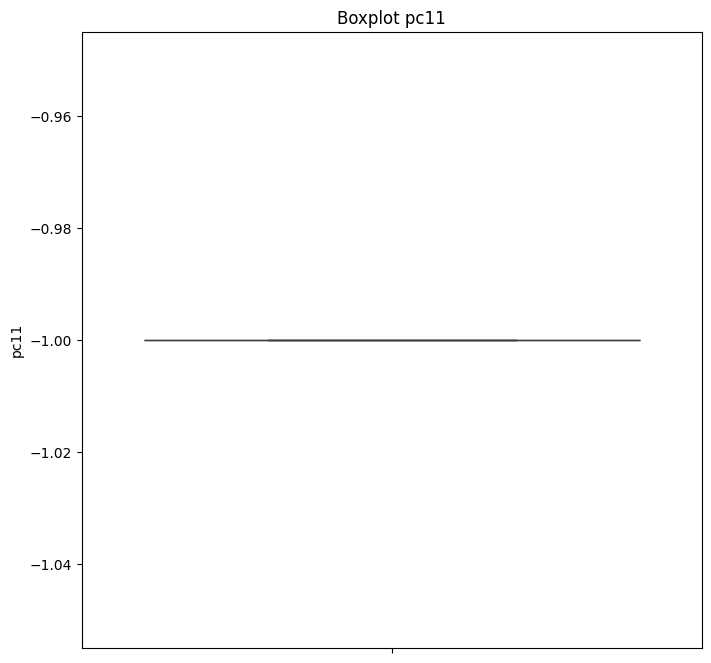

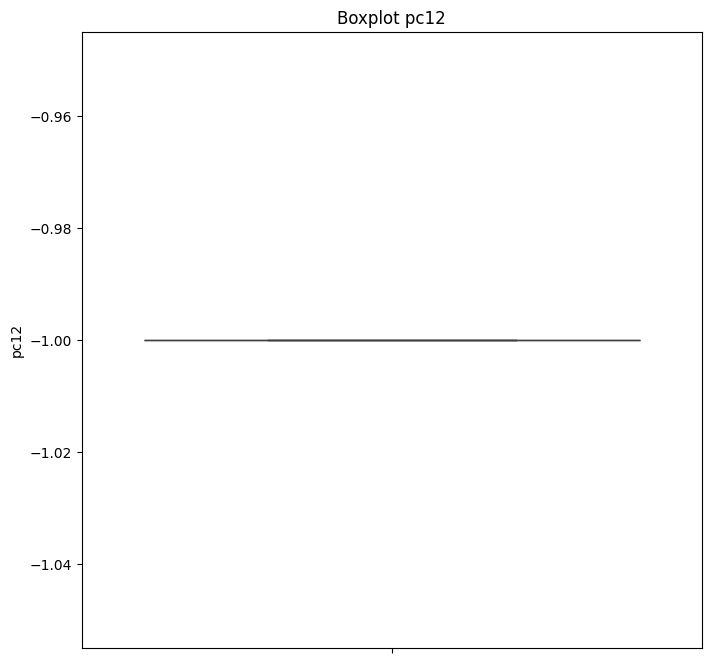

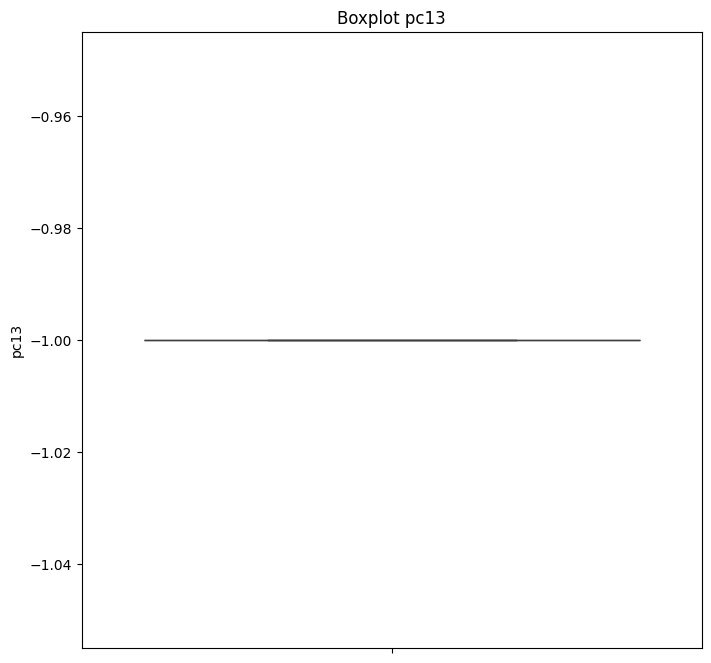

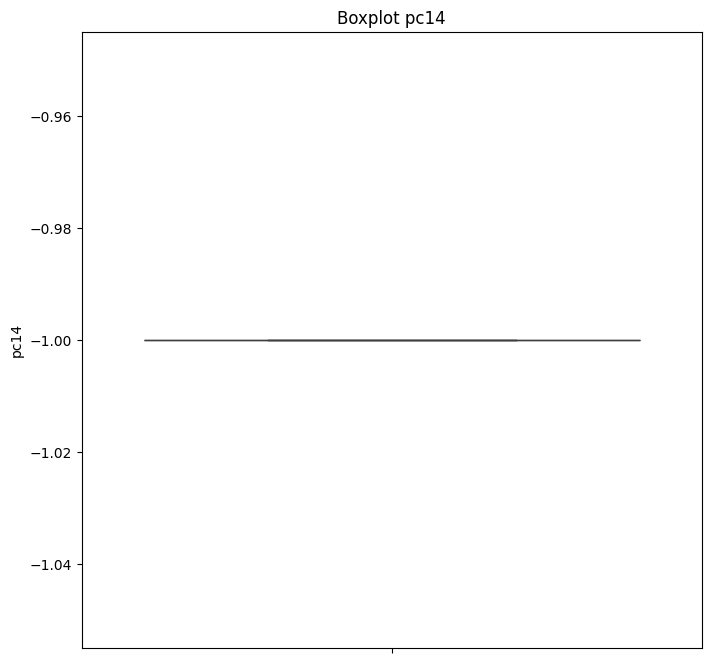

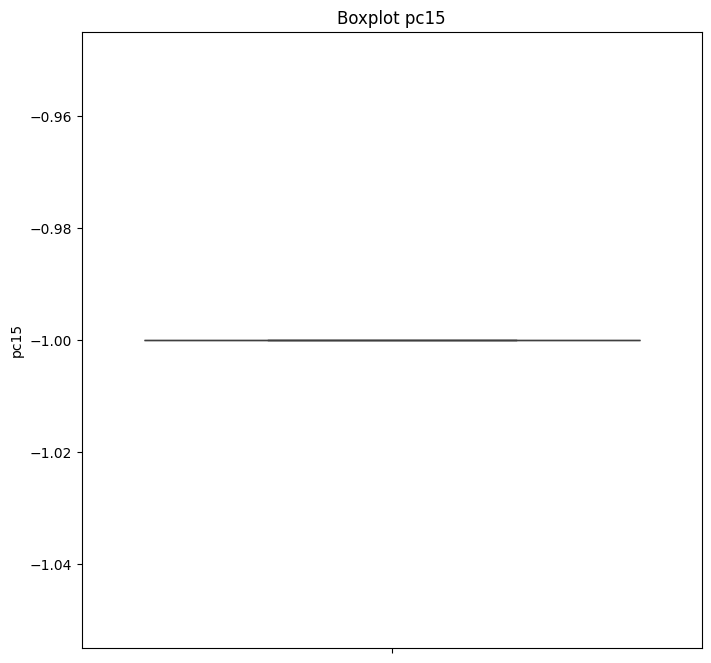

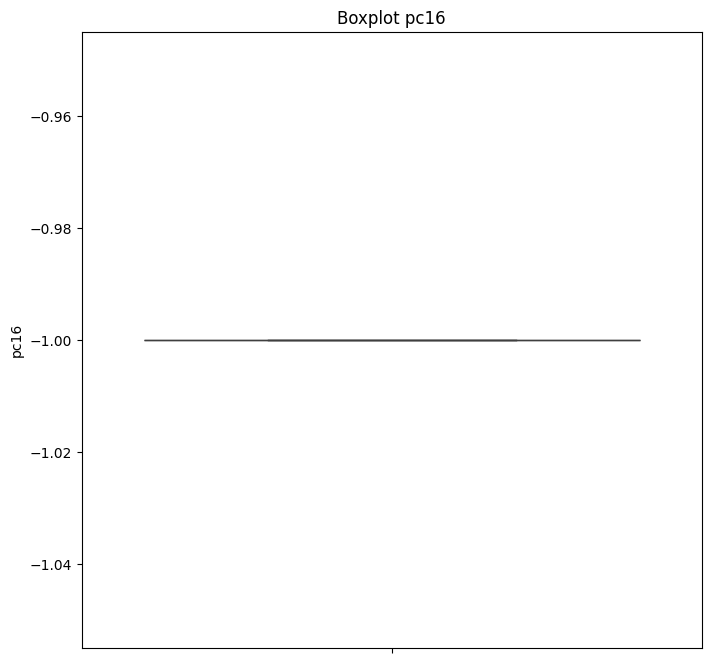

In [ ]:
# remove outlier menggunakan IQR method
def remove_outliers_iqr(data, feature):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

for feature in non_borrower_user.columns[1:]:
  non_borrower_user = remove_outliers_iqr(non_borrower_user, feature)
  plot(feature)

Menghapus outlier dari dataset non_borrower_user menggunakan metode IQR

## Normalization

In [ ]:
loan_activities['time_stamp_s'] = pd.to_datetime(loan_activities['ts'], unit='s')

format_waktu = format_waktu = '%H:%M:%S'

loan_activities['time_stamp_s'] = loan_activities['time_stamp_s'].dt.strftime(format_waktu)

Mengubah kolom timestamp dari satuan detik (ts) dalam loan_activities menjadi format waktu jam:menit:detik (h:m:s)

In [ ]:
print(loan_activities['time_stamp_s'].dtype)

print(loan_activities['time_stamp_s'])

object
0          00:11:11
1          00:01:29
2          00:03:50
3          00:02:00
4          00:00:57
             ...   
4300994    00:08:13
4300995    00:10:09
4300996    00:00:01
4300997    00:06:07
4300998    00:07:07
Name: time_stamp_s, Length: 4300999, dtype: object


### Normalization non-borrower user

In [ ]:
non_borrower_user['pc0'] = non_borrower_user['pc0'].astype('float64')
non_borrower_user['pc1'] = non_borrower_user['pc1'].astype('float64')
non_borrower_user['pc10'] = non_borrower_user['pc10'].astype('float64')

Mengubah tipe data pc0, pc1, dan pc10 pada dataset non_borrower_user dari int menjadi float64

In [ ]:
non_borrower_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676738 entries, 0 to 1048573
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  676738 non-null  int64  
 1   pc0      676738 non-null  float64
 2   pc1      676738 non-null  float64
 3   pc2      676738 non-null  float64
 4   pc3      676738 non-null  float64
 5   pc4      676738 non-null  float64
 6   pc5      676738 non-null  float64
 7   pc6      676738 non-null  float64
 8   pc7      676738 non-null  float64
 9   pc8      676738 non-null  float64
 10  pc9      676738 non-null  float64
 11  pc10     676738 non-null  float64
 12  pc11     676738 non-null  float64
 13  pc12     676738 non-null  float64
 14  pc13     676738 non-null  float64
 15  pc14     676738 non-null  float64
 16  pc15     676738 non-null  float64
 17  pc16     676738 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 98.1 MB


# Exploratory Data Analysis

##Labelling distribution (Fraud vs Non-Fraud) on train data

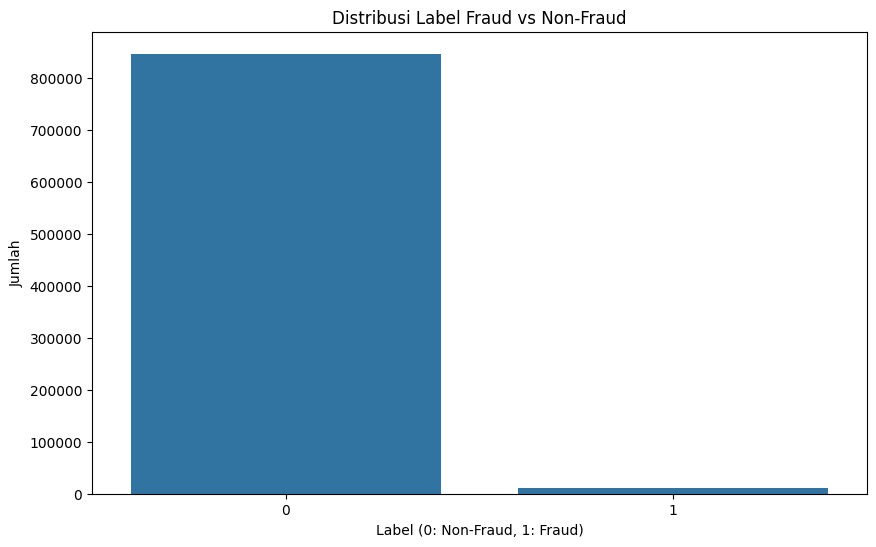

label
0    0.987345
1    0.012655
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train)
plt.title('Distribusi Label Fraud vs Non-Fraud')
plt.xlabel('Label (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Jumlah')
plt.show()

print(train['label'].value_counts(normalize=True))

Non fraud (0) vs fraud (1) label distribution
The bar on the left (label 0) is much higher than the bar on the right (label 1).
This indicates that there is a significant imbalance between non-fraud and fraud cases.

Non-Fraud Cases (Label 0):
The number is around 800,000 or more.
This represents the large majority of the dataset.

Fraud Cases (Label 1):
The number is much less, probably only around 20,000-30,000.
This represents a small minority of the dataset.

conclusion the dataset is very unbalanced

##Correlation between identity features in train data

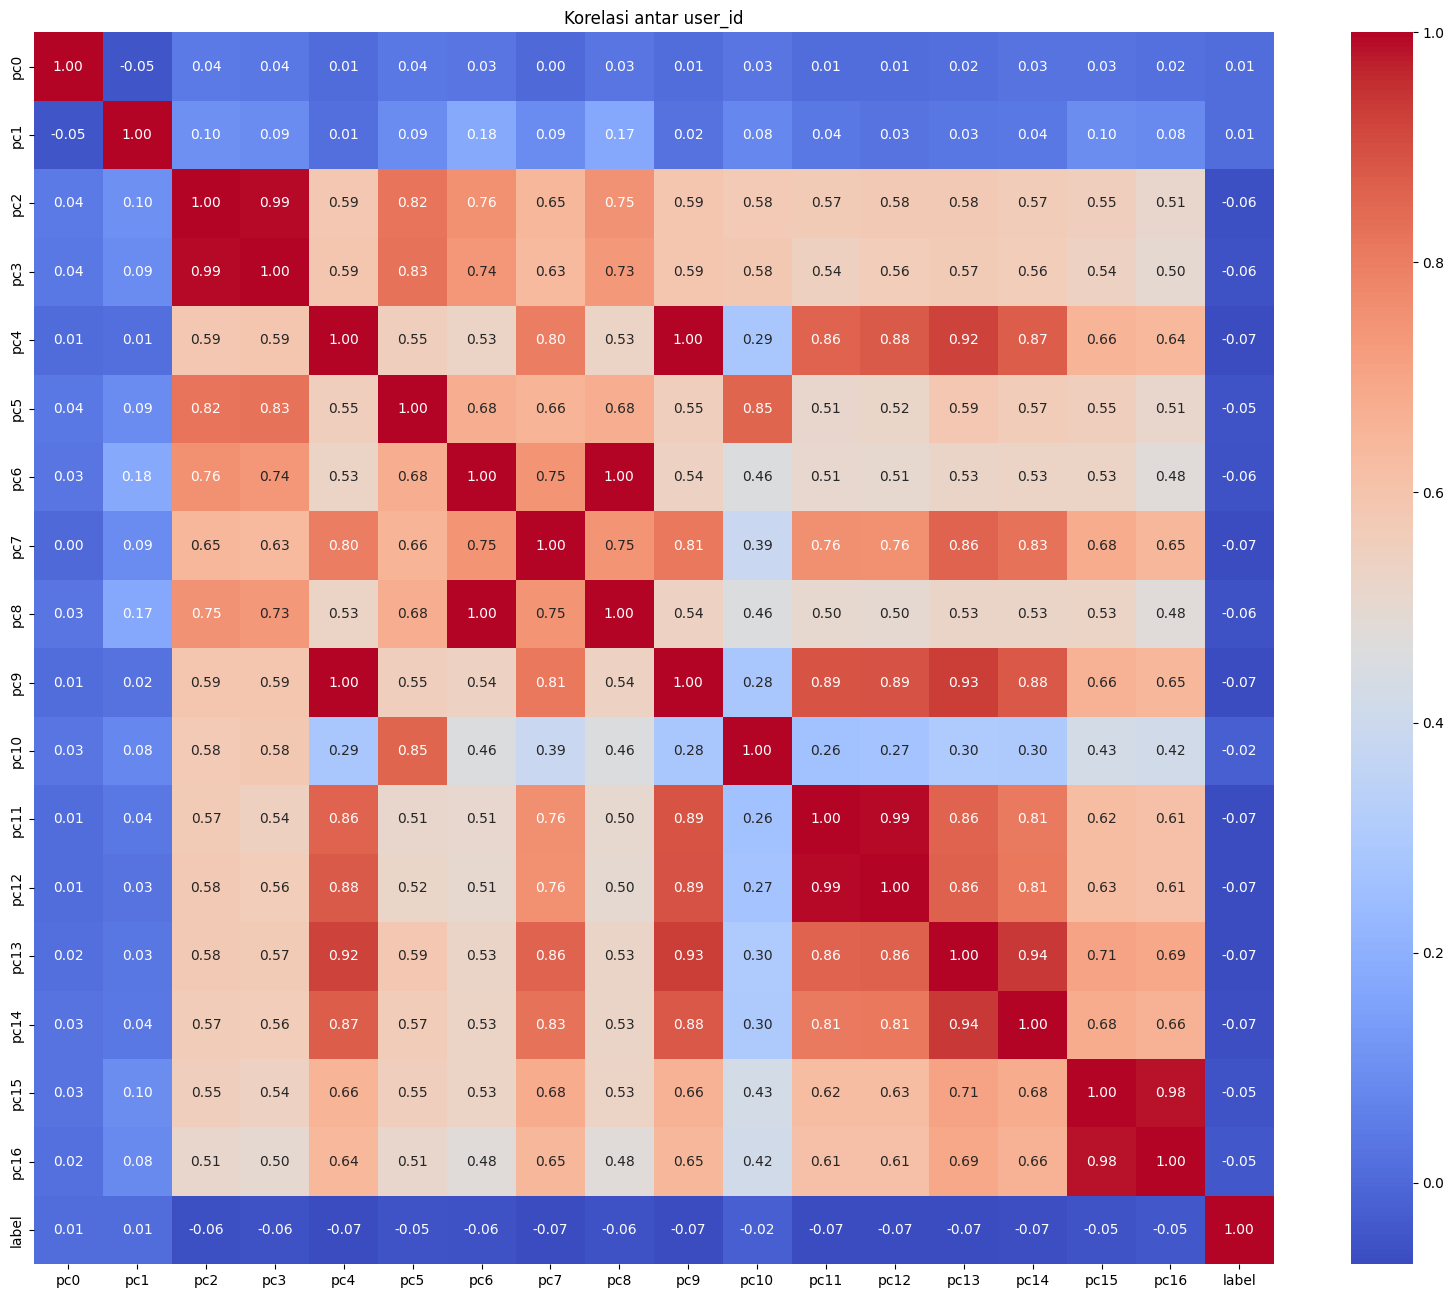

In [ ]:
plt.figure(figsize=(20, 16))
sns.heatmap(train.drop('user_id', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antar user_id')
plt.show()

This figure shows the correlation matrix between identity features in the dataset. Here are the interpretations and key implications:

1. High Correlation:
Some identity feature pairs have very high correlation (close to 1.0), for example:
pc2 and pc3 (0.99)
pc11 and pc12 (0.99)
pc15 and pc16 (0.98)
This indicates strong multicollinearity between the identity features.

2. Correlated identity feature groups:
There are several groups of highly correlated identity features, such as:
pc4, pc9, pc11, pc12, pc13, pc14
pc2, pc3, pc5
pc6, pc8

4. Independent identity features:
pc0 and pc1 appear relatively independent of other identity features, with low correlation to all other identity features.

5. Correlation Variation:
Most identity features have positive correlations with each other, with varying degrees.

##Analyse the loan amount per user:

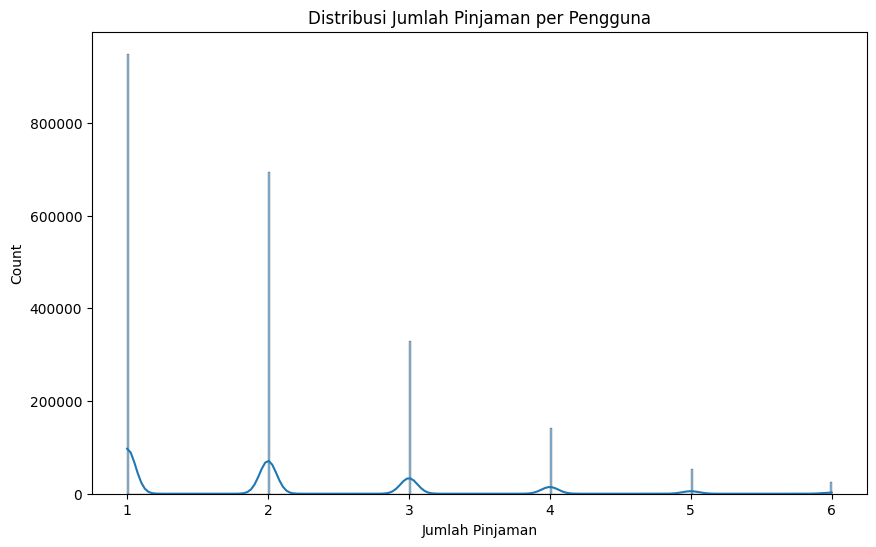

count    2.190662e+06
mean     1.963333e+00
std      1.112461e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: loan_count, dtype: float64


In [ ]:
loan_count = loan_activities['user_id'].value_counts().reset_index()
loan_count.columns = ['user_id', 'loan_count']

plt.figure(figsize=(10, 6))
sns.histplot(data=loan_count, x='loan_count', kde=True)
plt.title('Distribusi Jumlah Pinjaman per Pengguna')
plt.xlabel('Jumlah Pinjaman')
plt.show()

print(loan_count['loan_count'].describe())

The graph shown is the distribution of loan amounts per user. Here is the interpretation of the figure:

1. X-axis (Loan Amount): Shows the number of loans made by the user. The values on the X-axis range from 1 to 6.
2. Y-axis (Count): Shows the number of users who have a certain number of loans.
3. Distribution: It can be seen that most users have only one loan. The higher the loan amount, the fewer users fall into that category.

In detail:

Loan 1: More than 900,000 users have one loan.

Loan 2: About 600,000 users have two loans.

Loan 3: Around 200,000 users have three loans.

Loans 4, 5, and 6: The number of users with these loans is very small when compared to the number of users who have 1, 2, or 3 loans.

From this graph, we can conclude that the majority of users tend to have a small number of loans, with most users having only one loan.

##Missing Value Analysis:

         Missing Values  Percentage
user_id               0         0.0
pc0                   0         0.0
pc1                   0         0.0
pc2                   0         0.0
pc3                   0         0.0
pc4                   0         0.0
pc5                   0         0.0
pc6                   0         0.0
pc7                   0         0.0
pc8                   0         0.0
pc9                   0         0.0
pc10                  0         0.0
pc11                  0         0.0
pc12                  0         0.0
pc13                  0         0.0
pc14                  0         0.0
pc15                  0         0.0
pc16                  0         0.0
label                 0         0.0


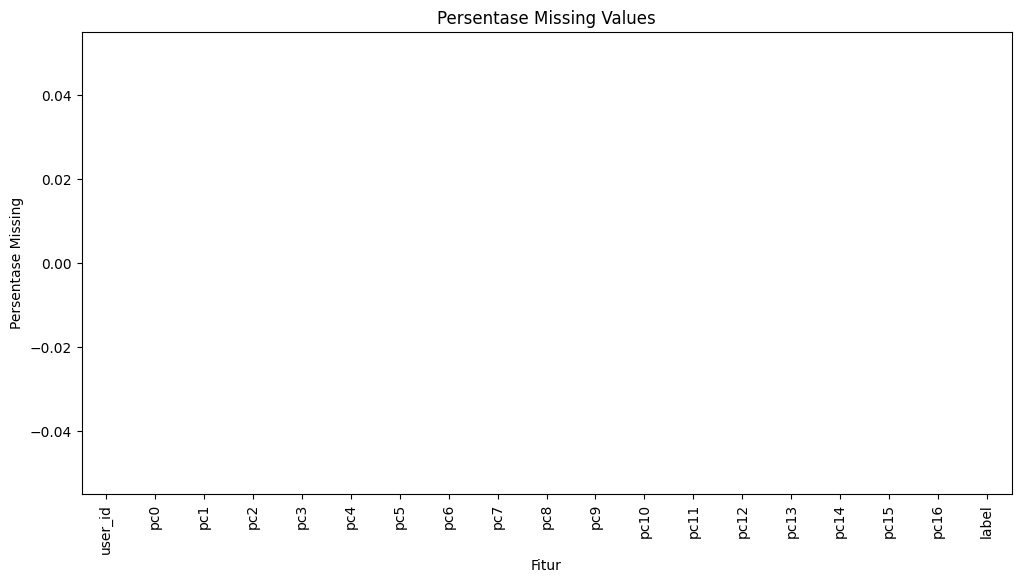

In [ ]:
missing_values = train.isnull().sum()
missing_percentages = 100 * missing_values / len(train)

missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_table)

plt.figure(figsize=(12, 6))
missing_table['Percentage'].plot(kind='bar')
plt.title('Persentase Missing Values')
plt.xlabel('Fitur')
plt.ylabel('Persentase Missing')
plt.show()

There are no missing values

##Analysing User Characteristics:

In [ ]:
def compare_feature_stats(feature):
    fraud = train[train['label'] == 1][feature]
    non_fraud = train[train['label'] == 0][feature]

    print(f"\nStatistik untuk {feature}:")
    print("Fraud:")
    print(fraud.describe())
    print("\nNon-Fraud:")
    print(non_fraud.describe())

for feature in train.columns[1:-1]:
    compare_feature_stats(feature)


Statistik untuk pc0:
Fraud:
count    10857.000000
mean         0.787787
std          0.409119
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: pc0, dtype: float64

Non-Fraud:
count    847042.000000
mean          0.746346
std           0.439884
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: pc0, dtype: float64

Statistik untuk pc1:
Fraud:
count    10857.000000
mean         3.884498
std          2.043087
min         -1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          8.000000
Name: pc1, dtype: float64

Non-Fraud:
count    847042.000000
mean          3.706804
std           1.933352
min          -1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           8.000000
Name: pc1, dtype: float64

Statistik untuk pc2:
Fraud:
count    10857.000000
mean        -0.459439
std          0.836222

1. Mean Difference:
For most identity features, there are significant mean differences between fraud and non-fraud cases.
For example, for pc2, the mean of fraud is -0.459439, while that of non-fraud is 0.558243.

2. Standard Deviation Variation:
Some identity features show large standard deviation differences between fraud and non-fraud.
This indicates a difference in variability in the data.

3. Range of Values:
Some identity features have different value ranges for fraud and non-fraud.
For example, pc2 for non-fraud has a maximum value of 111,815, much higher than fraud (8,805).

4. Quartile Distribution:
Differences in the median value (50%) and other quartiles indicate differences in the shape of the distribution.

5. Potential identity features for Fraud Detection:
Identity features with statistically significant differences between fraud and non-fraud can be strong indicators for fraud detection.
For example, pc4, pc9, pc11, pc12, pc13, and pc14 show clear differences.

6. Outliers:
Some identity features show outliers, especially in non-fraud cases (e.g. very high maximum values in pc2, pc3, pc5).

7. Discrete vs Continuous identity features:
Some identity features such as pc0 and pc1 appear more discrete, while others are more continuous.

## Comparison between borrowers and non-borrowers
Comparing pc[0-16] characteristics between users in train.csv and non_borrower_user.csv. and looking for significant differences that might distinguish the two groups.

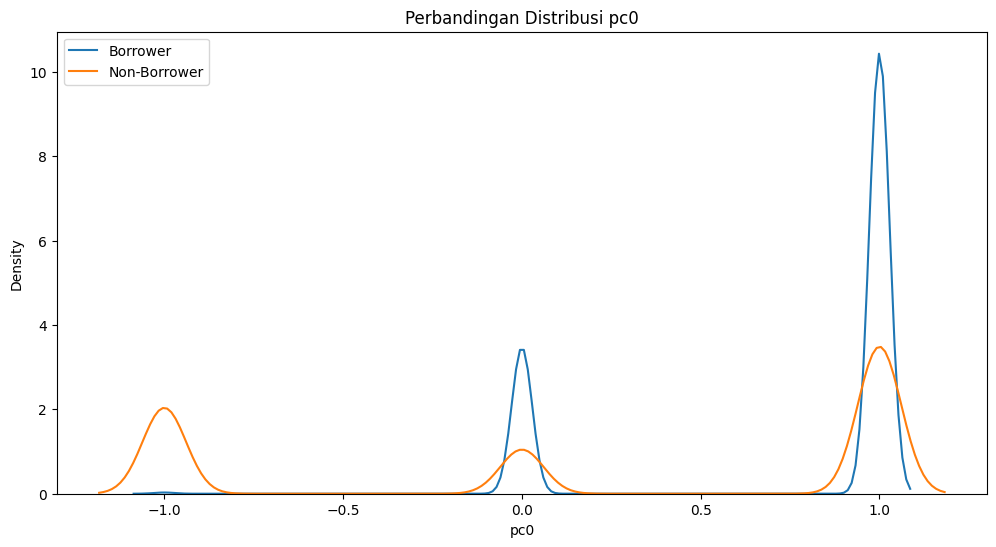

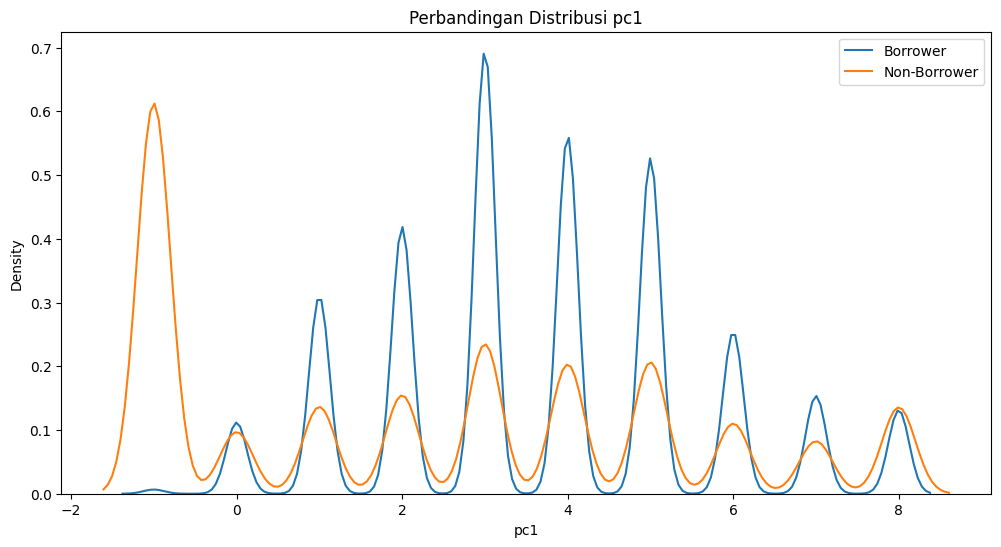

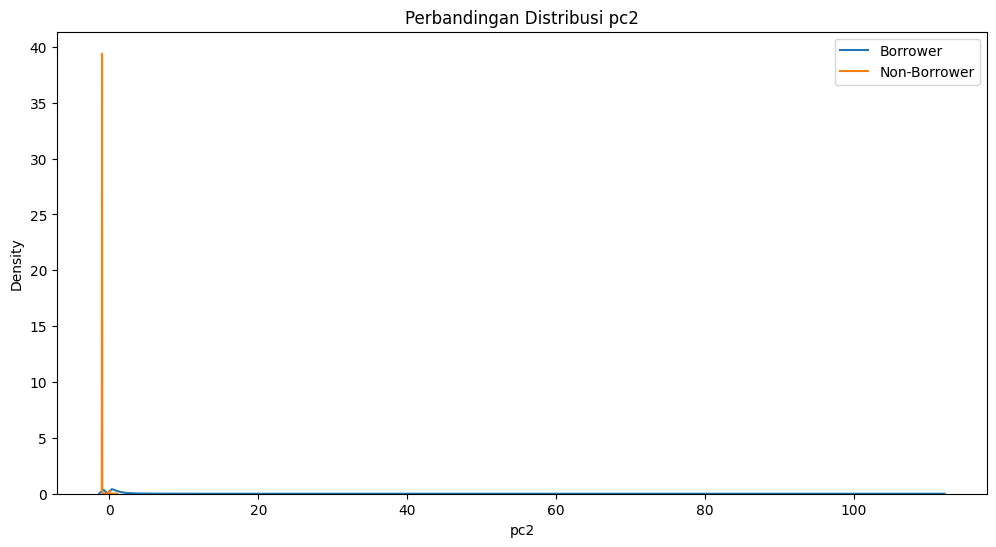

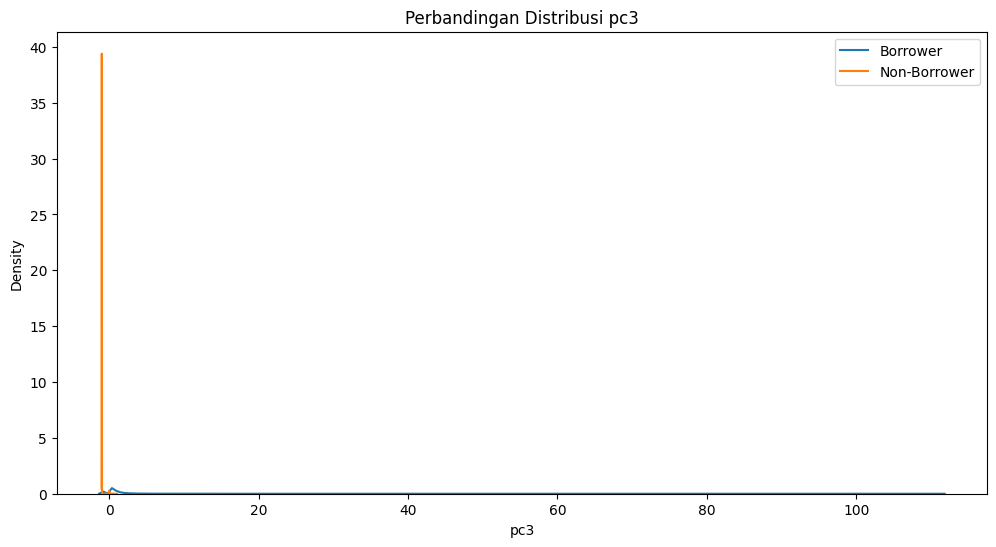

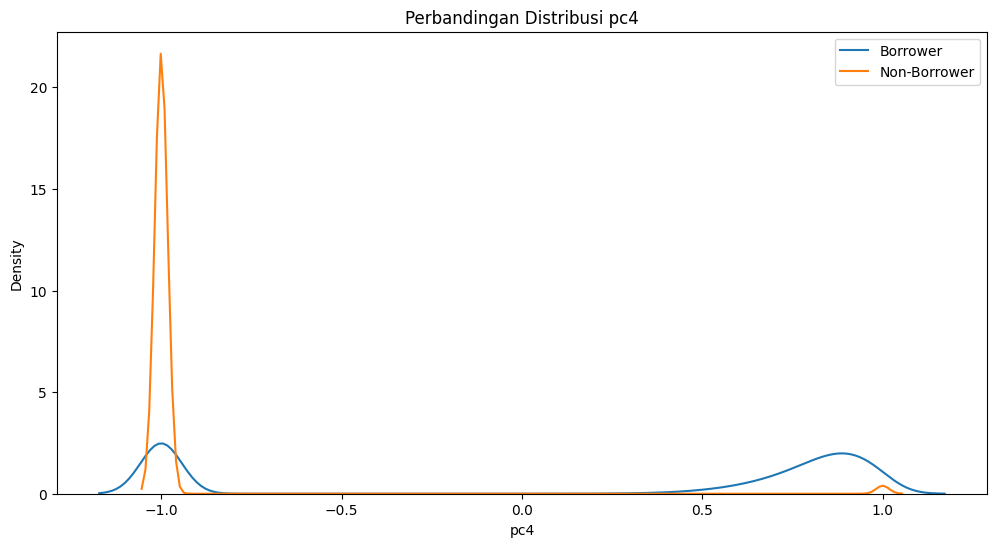

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


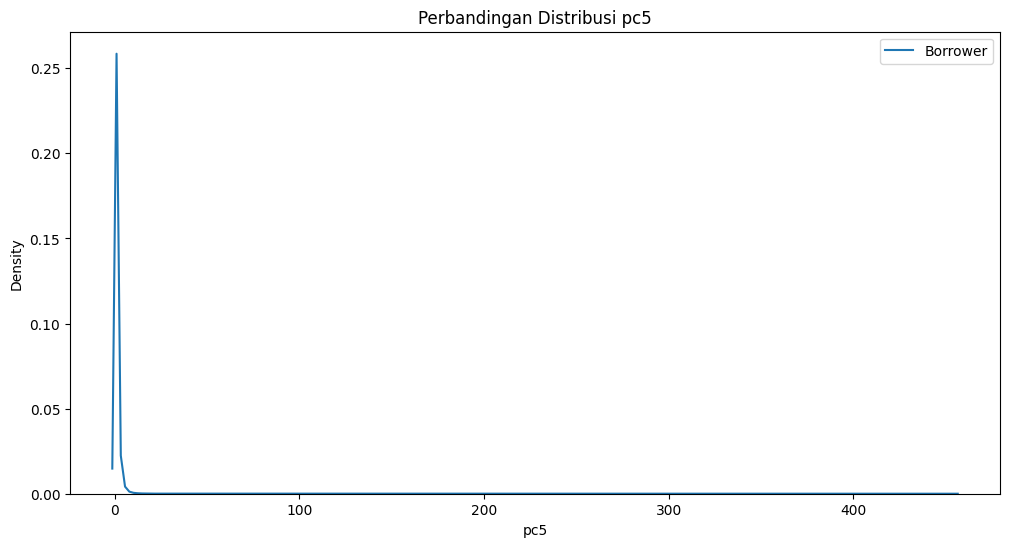

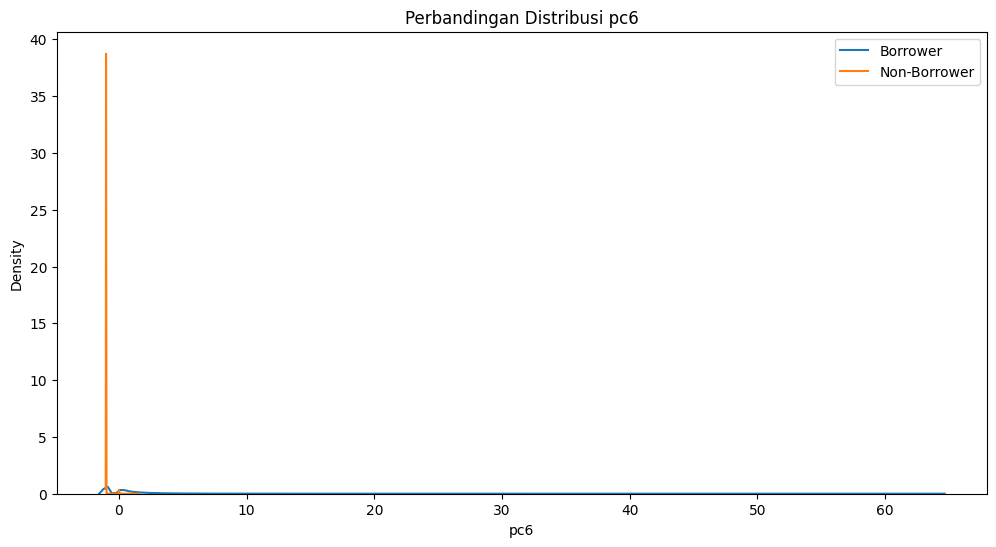

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


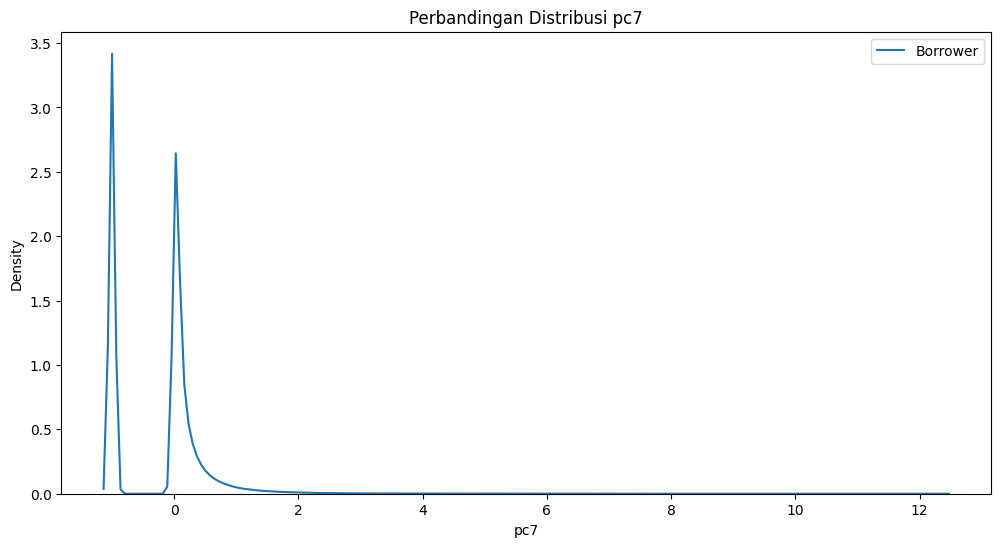

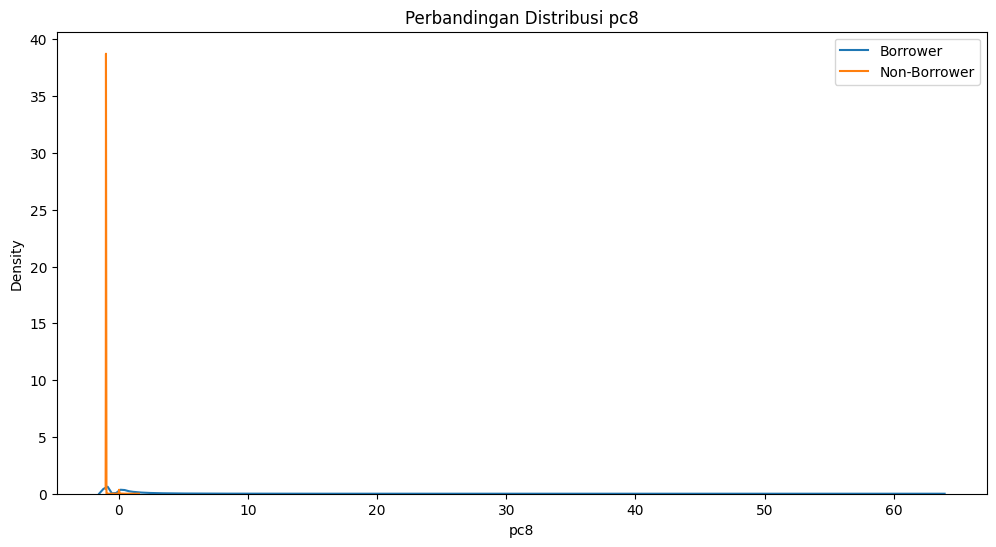

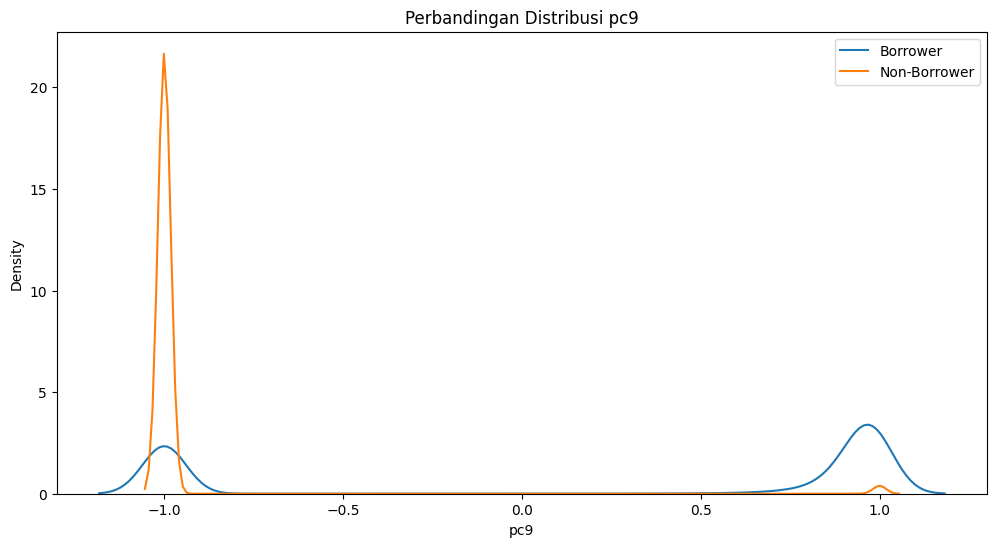

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


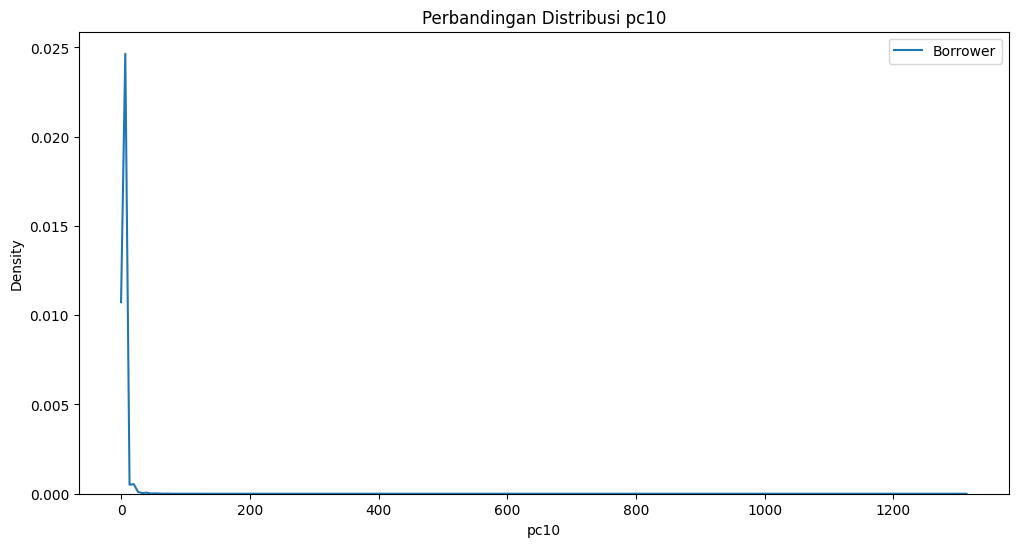

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


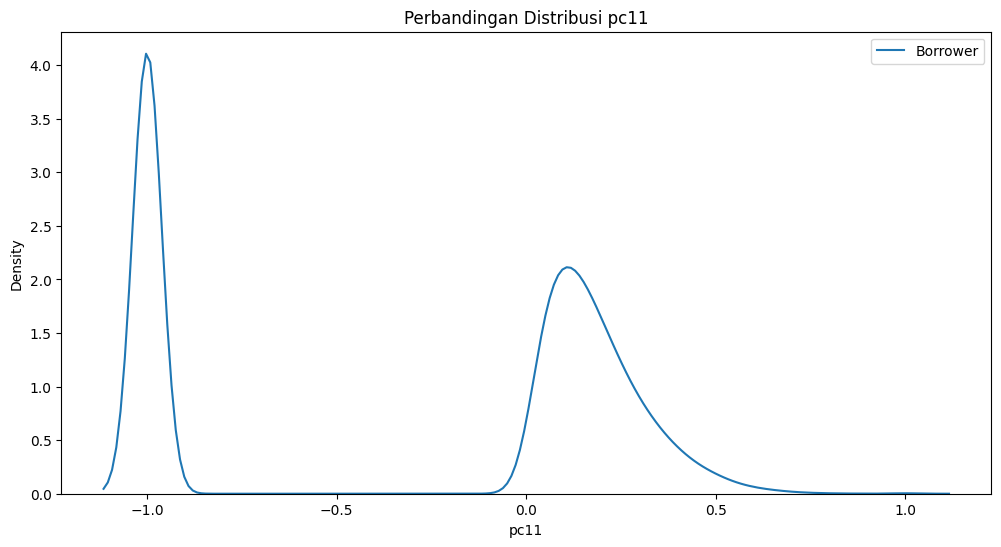

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


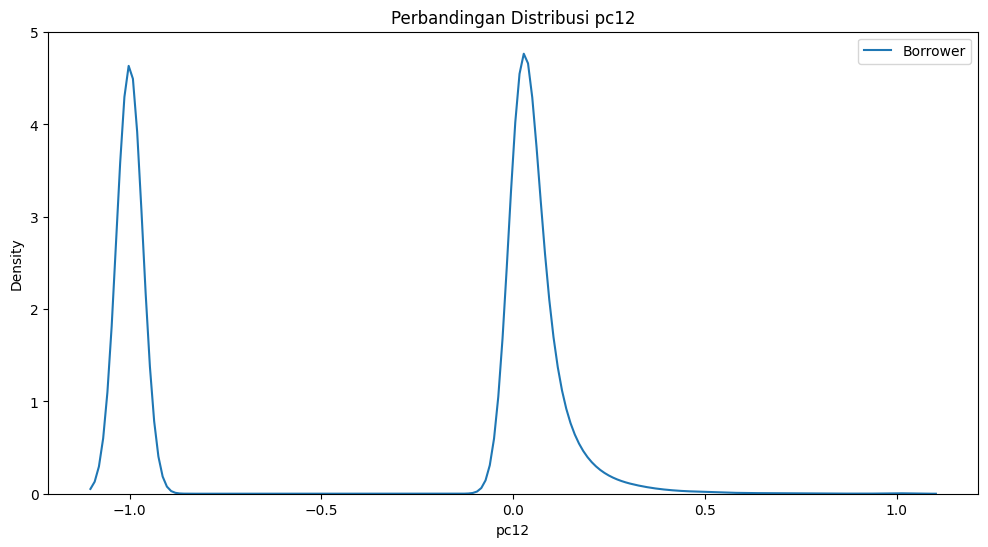

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


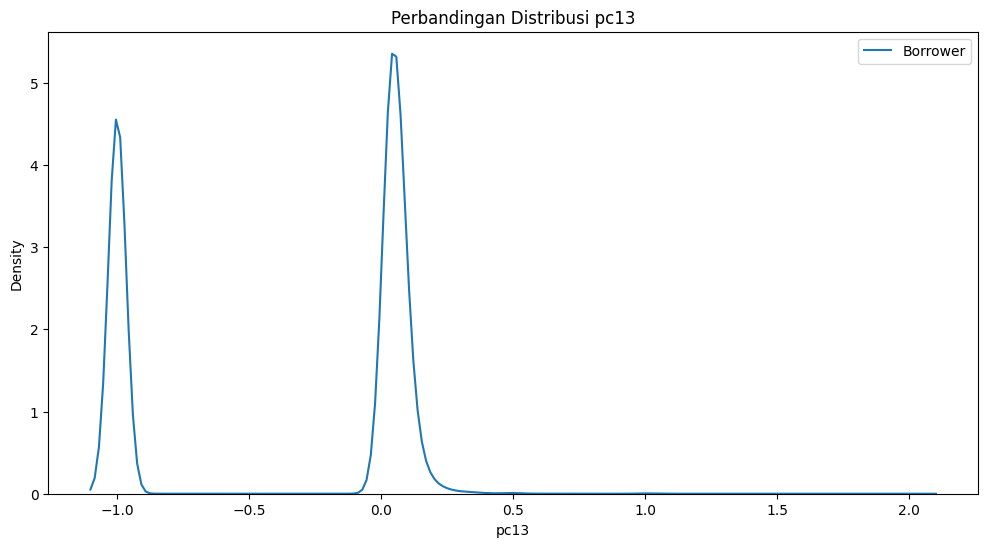

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


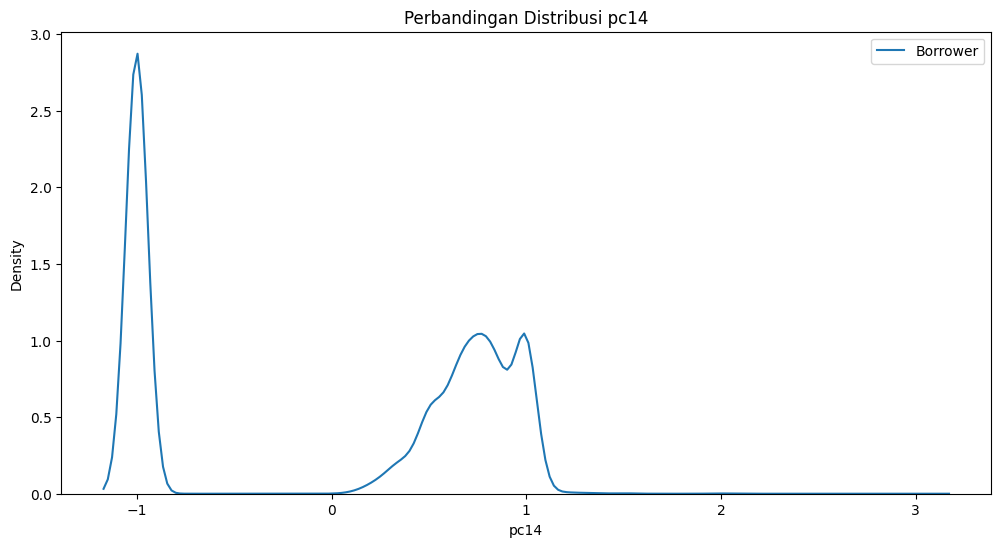

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


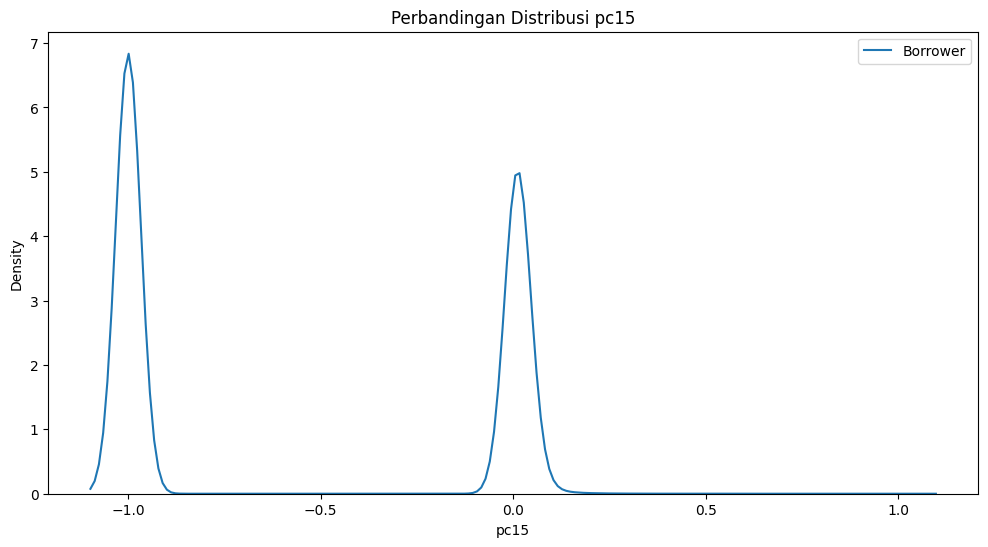

<ipython-input-33-d4f179eb674b>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')


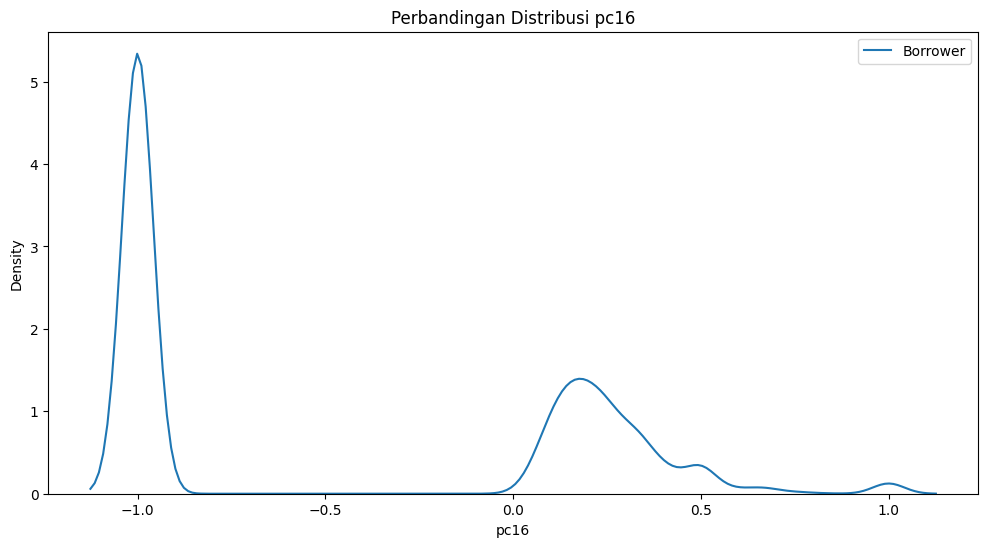

In [ ]:
def compare_borrower_nonborrower(train, non_borrower_user):
    for col in train.columns[train.columns.str.startswith('pc')]:
        plt.figure(figsize=(12, 6))
        sns.kdeplot(data=train, x=col, label='Borrower')
        sns.kdeplot(data=non_borrower_user, x=col, label='Non-Borrower')
        plt.title(f'Perbandingan Distribusi {col}')
        plt.legend()
        plt.show()

compare_borrower_nonborrower(train, non_borrower_user)

1. the distribution shapes of pc2, pc3, pc5, pc6, pc8 and pc10 are very skewed to the left, data transformation or outlier handling is required before modelling.
2. from all these graphs, it indicates that the data has a complex and non-linear pattern. This suggests that the separation between Borrowers and Non-Borrowers may require a better model.

## Borrower type distribution data

In [ ]:
def analyze_loan_activities(loan_activities):

    # Distribusi tipe pinjaman
    plt.figure(figsize=(10, 6))
    sns.countplot(x='loan_type', data=loan_activities)
    plt.title('Distribusi Tipe Pinjaman')
    plt.show()

analyze_loan_activities(loan_activities)

The x-axis shows the loan type numbered from 1 to 11.
The y-axis shows the number (count) of loans in millions (1e6 = 1,000,000).

Some important points:
1. Loan type 5 has the highest frequency, reaching around 1.6 million loans.
2. Loan type 4 is the second most frequent, with around 900,000 loans.
3. Loan type 6 came in third, with around 600,000 loans.
4. Loan type 1 has about 400,000 loans.
5. The other loan types (2, 3, 7, 8, 9, 10, 11) have a relatively lower frequency, below 300,000 loans.

General conclusions:
1. There is significant variation in the popularity of different loan types.
2. Loan type 5 is highly dominant compared to the others.
2. Some loan types are rarely used (e.g. 2, 7).

##Comparison of identity feature distribution between train and test set:

Compare the characteristics of pc[0-16] between users in train.csv and non_borrower_user.csv.
And look for significant differences that might distinguish the two groups.

In [ ]:
def compare_train_test_distribution(train, test):
    for col in train.columns[train.columns.str.startswith('pc')]:
        plt.figure(figsize=(12, 6))
        sns.kdeplot(data=train, x=col, label='Train')
        sns.kdeplot(data=test, x=col, label='Test')
        plt.title(f'Perbandingan Distribusi {col} (Train vs Test)')
        plt.legend()
        plt.show()

compare_train_test_distribution(train, test)

For all the identity features shown, the distributions between the train and test data are very similar. This is a positive indication that there is no significant difference between the characteristics of the train and test data.

Features pc2, pc3, pc5, pc8 and pc10 have very left skewed distributions, which may require transformation or handling in outliers.

##EDA conclusion for ML model

Conclusions for machine learning models:

1. Overcome class imbalance with techniques such as oversampling, undersampling, or SMOTE.
2. Perform feature selection to reduce multicollinearity, focusing on more independent features (pc0 and pc1).
3. Consider feature transformation, especially for pc2, pc3, pc5, pc8, and pc10 which have left skewed distributions.
4. Use appropriate evaluation metrics for unbalanced datasets, such as AUC-ROC or F1-score.
5. Choose a model that can handle data imbalance and multicollinearity, such as Random Forest or XGBoost.
6. or combining multiple models such as XGBoost, Random Forest, and Neural Networks can improve accuracy.

# Feature Engineering

Several steps were taken to enhance feature representation and address data imbalance. Here are the detailed steps:

*   **Calculate Median Transaction Time for Each User**: The median time between a user's transactions was calculated and added as a feature median_time_diff to both the training and test datasets.
*   **Calculate Loan Count for Each User**: The total number of loans taken by each user was calculated and added as a feature loan_count to both the training and test datasets.
*   **Use the Most Common Loan Type for Each User**: The most common loan type for each user was identified and added as a feature most_common_loan_type.
*   **Handle Imbalanced Data with SMOTE**: The SMOTE (Synthetic Minority Over-sampling Technique) method was used to balance the dataset by adding synthetic samples to the minority class.





## Calculate Median Transaction Time for Each User

In [ ]:
# Calculate median time difference for each user
median_waktu_transaksi = loan_activities.groupby('user_id')['ts'].median().reset_index()
median_waktu_transaksi.columns = ['user_id', 'median_time_diff']
train_cleaned = train_cleaned.merge(median_waktu_transaksi, on='user_id', how = 'left')
test = test.merge(median_waktu_transaksi, on = 'user_id', how = 'left')

In [ ]:
# Fill missing value with 0
train_cleaned['median_time_diff'].fillna(0, inplace = True)
test['median_time_diff'].fillna(0,inplace=  True)

## Calculate Loan Count For Each User

In [ ]:
# Calculate loan count for each user
loan_count = loan_activities.groupby('user_id').size().reset_index(name='loan_count')
train_cleaned = train_cleaned.merge(loan_count, on='user_id', how='left')
test = test.merge(loan_count, on='user_id', how='left')

In [ ]:
# Fill missing value with 0
train_cleaned['loan_count'].fillna(0, inplace=True)
test['loan_count'].fillna(0, inplace=True)

## Most Common Loan Type for Each User

In [ ]:
# Use the most common loan type for each user
most_common_loan_type = loan_activities.groupby('user_id')['loan_type'].agg(lambda x: x.value_counts().index[0]).reset_index()
most_common_loan_type.columns = ['user_id', 'most_common_loan_type']
train_cleaned = train_cleaned.merge(most_common_loan_type, on='user_id', how='left')
test=test.merge(most_common_loan_type, on = 'user_id', how = 'left')

In [ ]:
# One-hot encode the most_common_loan_type
train_cleaned = pd.get_dummies(train_cleaned, columns=['most_common_loan_type'], prefix='loan_type').astype(int)
test = pd.get_dummies(test, columns=['most_common_loan_type'], prefix='loan_type').astype(int)

## Handle Imbalanced Data With SMOTE

In [ ]:
X = train.drop(['user_id', 'label'], axis=1)
y = train['label']
y.value_counts().plot.pie(autopct = '%.2f%%')

In [ ]:
# Handle imbalanced data with SMOTE
smote = SMOTE(random_state=2024)

X_res, y_res = smote.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct = "%.2f%%")
pie = ax.set_title("oversampling - SMOTE")

# Modeling

The process of building machine learning model involves several key steps:


1.   Split Data Into Training and validation Sets
2.   Standardize Features
3.   Train XGBoost Model




The oversampled data (X_res, y_res) is divided into training and validation sets using an 80-20 split. Stratification ensures that the proportion of fraud and non-fraud cases is consistent in both sets.

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=2024, stratify=y_res)

Feature scaling is performed using StandardScaler to ensure that the features have a mean of 0 and a standard deviation of 1. This helps the model perform better. The scaler is fitted on the training data and then applied to the validation and test data.

In [ ]:
# StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test.drop('user_id', axis=1))

An XGBoost classifier is initialized with specified parameters such as n_estimators, learning_rate, and max_depth. The model is trained on the training set and evaluated on the validation set. Early stopping is used to prevent overfitting by stopping training if the validation performance does not improve for 10 rounds.

In [ ]:
# Train XGBoost model with specified parameters
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=2024,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    subsample = 0.7,
    colsample_bytree = 0.7,
    min_child_weight =1,
    gamma = 0.1,
    reg_lambda = 1
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Result and Analysis

The performance of the trained model is evaluated using various metrics and methods



Predict and Evaluate: Predictions on the validation set are made, and the average_precision_score is calculated to evaluate the precision-recall performance. The confusion matrix and classification report are generated to provide detailed insights into the model's performance.

In [ ]:
y_val_pred_proba = model.predict(X_val)
average_precision = average_precision_score(y_val, y_val_pred_proba)
conf_matrix = confusion_matrix(y_val, y_val_pred_proba)
class_report = classification_report(y_val, y_val_pred_proba)
print(f'Average Precision Score: {average_precision}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

To further assess the model's performance, 5-fold cross-validation is conducted on the oversampled data. The average_precision metric is used for scoring. The cross-validated scores and their mean provide an estimate of the model's generalization performance.

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X_res, y_res, cv=5, scoring='average_precision')
print(f'Cross-validated scores: {cv_scores}')
print(f'Mean cross-validated score: {cv_scores.mean()}')

Cross-validated scores: [0.87670079 0.88391141 0.88441359 0.88502974 0.88461225]
Mean cross-validated score: 0.8829335547554553


# Conclusions

The XGBoost model has achieved a high average precision score of 0.8315. It has a precision of 0.98 for non-fraud and 0.84 for fraud, with corresponding recall scores of 0.81 and 0.99. The overall accuracy is 0.90, demonstrating its strong performance in classifying the data accurately.

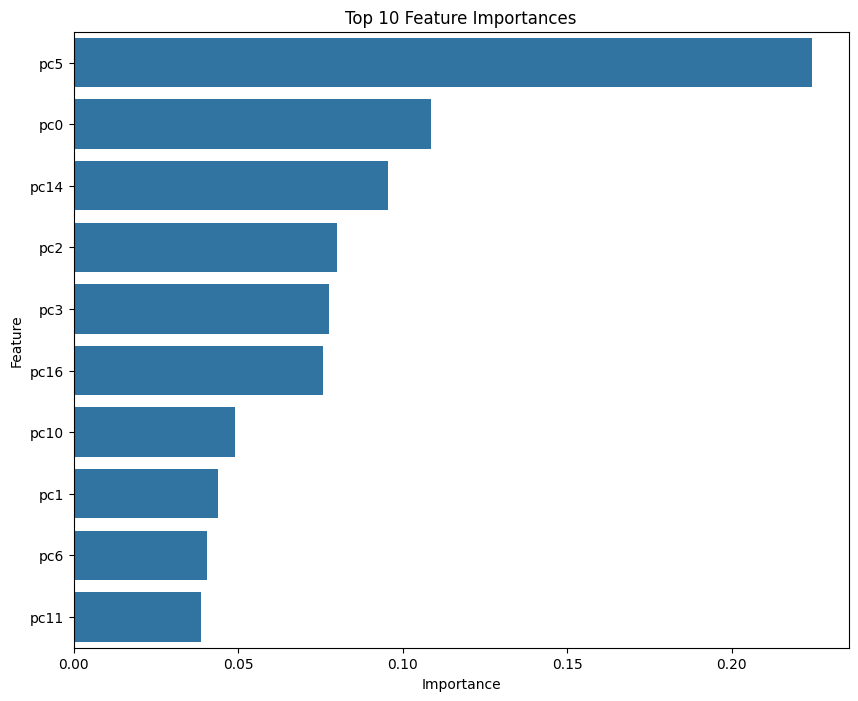

In [ ]:
# top 10 feature importances
# Get feature importances
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()

Based on the graph, it can be seen that the "loan_type_3.0" feature has the highest importance, followed by "loan_type_6.0", "loan_type_1.0", and so on. This indicates that the "loan_type_3.0" feature has the greatest influence in determining whether a transaction is fraudulent or not. The "loan_count" feature also has a relatively high importance, suggesting that the number of loans applied for by an individual can also be an indicator of fraud.